# Property Price By Country

## Import Libraries

In [1]:
import empiricaldist #A library for empirical distributions.
import janitor #A library for cleaning data.
import matplotlib.pyplot as plt #A library for plotting.
import numpy as np #A library for numerical operations.
import pandas as pd #A library for data manipulation.
import seaborn as sns #A library for creating statistical graphics
import sklearn.metrics #A library for evaluating machine learning models.
import statsmodels.api as sm #A library for statistical models.
import statsmodels.formula.api as smf # A library for specifying statistical models using formulas.
import statsmodels.stats as ss #A library for statistical tests.
import scipy.stats #A library for statistical functions and distributions.
from sklearn.neighbors import KernelDensity #A library for estimating probability density functions using kernel density estimation.
import missingno #A library for visualizing missing data patterns.

In [2]:
%run pandas-missing-extension.ipynb #called the pandas-missing-extension notebook

## Graphics Appearance

In [3]:
"""
This code sets up the plotting environment for visualizing the cost of living data by continent.

It imports the necessary libraries and sets the plotting style, context, and figure size.
It also defines a dictionary that maps each continent to a specific color.

"""

%matplotlib inline
sns.set_style(rc={'axes.facecolor':'#dddede'}, style = 'darkgrid')
sns.set_context(context='notebook')
plt.rcParams['figure.figsize'] = (9, 6)


continent_color = {
    'America': '#97DB4F',
    'Europe': '#0f7175ff',
    'Asia' :'#c65dc9ff',
    'Oceania':'#F9704E',
    'Africa': '#53d8fb'
}

Note that there is no standard formula to calculate property price indices. Our formulas differs from Case-Shiller Index, UK Housing Price Index, etc.

* **Price to Income Ratio** is the basic measure for apartment purchase affordability (lower is better).

    * Net disposable family income, as defined as 1.5 * the average net salary (50% is assumed percentage of women in the workforce)
    * Median apartment size is 90 square meters
    * Price per square meter (the formula uses) is the average price of square meter in the city center and outside of the city center

* **Gross Rental Yield** is the total yearly gross rent divided by the house price (expressed in percentages). Higher is better.

* **Price to Rent Ratio** is the average cost of ownership divided by the received rent income (if buying to let) or the estimated rent that would be paid if renting (if buying to reside). 
    * Lower values suggest that it is **better to buy** rather than rent, and higher values suggest that it is **better to rent** rather than buy. 
        * rent per square meter assumes 1 bedroom apt has 50 square meters and 3 bedroom apartment has 110 square meters. 
        * It doesn't take into account taxes or maintenance fees.


* **Mortgage as Percentage of Income** is a ratio of the actual monthly cost of the mortgage to take-home family income (lower is better). Average monthly salary is used to estimate family income. It assumes 100% mortgage is taken on 20 years for the house(or apt) of 90 square meters which price per square meter is the average of price in the city center and outside of city center.

* **Loan Affordability Index** is an inverse of mortgage as percentage of income. Used formula is : (100 / mortgage as percentage of income) (higher is better).

[Font](https://www.numbeo.com/property-investment/indicators_explained.jsp)

In [5]:
df_prop = pd.read_csv('../data/property/property-2023-mid.csv')

In [6]:
df_prop.columns

Index(['Country', 'Price_to_Income', 'Gross_Rental_Ce', 'Gross_Rental_Out',
       'Price_Ratio_Ce', 'Price_Ratio_Out', 'Mortgage_As_Percentage',
       'Affordability'],
      dtype='object')

## Create a new column, continent

In [7]:
continents = {
    'Africa': ['Angola','Zambia','Seychelles','Mozambique', 'Somalia','Senegal', 'Ivory Coast', 'Ethiopia', 'Mauritius', 'Zimbabwe', 'South Africa', 'Namibia', 'Botswana', 'Cameroon', 'Kenya', 'Uganda', 'Nigeria', 'Tanzania', 'Rwanda', 'Morocco', 'Algeria', 'Ghana', 'Tunisia', 'Libya', 'Egypt'],
    'America': ['Suriname','Us Virgin Islands', 'Bermuda', 'Cayman Islands', 'Bahamas', 'Barbados', 'United States', 'Puerto Rico', 'Canada', 'Uruguay', 'Jamaica', 'Trinidad And Tobago', 'Cuba', 'Costa Rica', 'Panama', 'Belize', 'Guyana', 'Chile', 'El Salvador', 'Dominican Republic', 'Venezuela', 'Guatemala', 'Honduras', 'Mexico', 'Nicaragua', 'Ecuador', 'Brazil', 'Peru', 'Bolivia', 'Argentina', 'Paraguay', 'Colombia'],
    'Asia': ['Macao','Singapore','Taiwan', 'Hong Kong', 'Afghanistan','Israel', 'Hong Kong (China)', 'South Korea', 'Macao (China)', 'Lebanon', 'Japan', 'United Arab Emirates', 'Qatar', 'Yemen', 'Cyprus', 'Brunei', 'Maldives', 'Taiwan (China)', 'Bahrain', 'Palestine', 'Saudi Arabia', 'Oman', 'Kuwait', 'Jordan', 'Cambodia', 'Armenia', 'Thailand', 'China', 'Georgia', 'Vietnam', 'Iran', 'Malaysia', 'Philippines', 'Myanmar', 'Iraq', 'Mongolia', 'Indonesia', 'Azerbaijan', 'Kazakhstan', 'Turkey', 'Uzbekistan', 'Bangladesh', 'Syria', 'Kyrgyzstan', 'Sri Lanka', 'Nepal', 'India', 'Pakistan'],
    'Europe': ['Switzerland', 'Norway', 'Monaco','Iceland', 'Jersey', 'Denmark', 'Luxembourg', 'Guernsey', 'Ireland', 'France', 'Netherlands', 'Finland', 'Austria', 'Belgium', 'Germany', 'Sweden', 'Isle Of Man', 'United Kingdom', 'Malta', 'Italy', 'Estonia', 'Greece', 'Latvia', 'Slovenia', 'Spain', 'Czech Republic', 'Lithuania', 'Croatia', 'Portugal', 'Slovakia', 'Russia', 'Bulgaria', 'Hungary', 'Montenegro', 'Poland', 'Albania', 'Romania', 'Serbia', 'Belarus', 'Bosnia And Herzegovina', 'Moldova', 'North Macedonia', 'Kosovo (Disputed Territory)', 'Ukraine'],
    'Oceania': ['Australia', 'New Zealand', 'Fiji', 'Papua New Guinea',]
}

dictionary = {}

for continent, countries in continents.items():
    dictionary.update(dict.fromkeys(countries, continent))

df_prop['Continente'] = df_prop['Country'].map(dictionary)

In [8]:
# look if some country is out of the dictionary
df_prop['Continente'].isnull().value_counts()

False    106
Name: Continente, dtype: int64

In [9]:
df_prop[df_prop['Continente'].isnull()]['Country'].unique()

array([], dtype=object)

## Exploring data

In [10]:
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 106 non-null    object 
 1   Price_to_Income         106 non-null    float64
 2   Gross_Rental_Ce         106 non-null    float64
 3   Gross_Rental_Out        106 non-null    float64
 4   Price_Ratio_Ce          106 non-null    float64
 5   Price_Ratio_Out         106 non-null    float64
 6   Mortgage_As_Percentage  106 non-null    float64
 7   Affordability           106 non-null    float64
 8   Continente              106 non-null    object 
dtypes: float64(7), object(2)
memory usage: 7.6+ KB


In [11]:
df_prop.describe()

,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,14.626415,5.031132,5.300943,24.468868,22.862264,168.037736,1.103774
std,11.312937,2.200838,2.259814,13.101656,11.950361,191.546676,0.828645
min,2.900000,1.200000,1.200000,8.900000,8.400000,21.800000,0.100000
25%,9.200000,3.300000,3.800000,15.900000,15.400000,68.600000,0.500000
50%,12.300000,4.500000,4.900000,22.100000,20.300000,108.800000,0.900000
75%,15.850000,6.300000,6.500000,30.175000,26.475000,197.450000,1.475000
max,99.500000,11.200000,11.900000,85.900000,86.600000,1306.600000,4.600000


In [12]:
df_prop.dtypes

Country                    object
Price_to_Income           float64
Gross_Rental_Ce           float64
Gross_Rental_Out          float64
Price_Ratio_Ce            float64
Price_Ratio_Out           float64
Mortgage_As_Percentage    float64
Affordability             float64
Continente                 object
dtype: object

In [13]:
(
    df_prop
    .dtypes
    .value_counts()
)

float64    7
object     2
dtype: int64

In [14]:
df_prop.describe(include = (np.number))

,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,14.626415,5.031132,5.300943,24.468868,22.862264,168.037736,1.103774
std,11.312937,2.200838,2.259814,13.101656,11.950361,191.546676,0.828645
min,2.900000,1.200000,1.200000,8.900000,8.400000,21.800000,0.100000
25%,9.200000,3.300000,3.800000,15.900000,15.400000,68.600000,0.500000
50%,12.300000,4.500000,4.900000,22.100000,20.300000,108.800000,0.900000
75%,15.850000,6.300000,6.500000,30.175000,26.475000,197.450000,1.475000
max,99.500000,11.200000,11.900000,85.900000,86.600000,1306.600000,4.600000


In [15]:
df_prop.mean()

/tmp/ipykernel_1706/2520740389.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_prop.mean()


Price_to_Income            14.626415
Gross_Rental_Ce             5.031132
Gross_Rental_Out            5.300943
Price_Ratio_Ce             24.468868
Price_Ratio_Out            22.862264
Mortgage_As_Percentage    168.037736
Affordability               1.103774
dtype: float64

In [16]:
df_prop.median()

/tmp/ipykernel_1706/3019833171.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_prop.median()


Price_to_Income            12.3
Gross_Rental_Ce             4.5
Gross_Rental_Out            4.9
Price_Ratio_Ce             22.1
Price_Ratio_Out            20.3
Mortgage_As_Percentage    108.8
Affordability               0.9
dtype: float64

In [17]:
df_prop.mode(axis = 0, numeric_only= True, dropna = True)

,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability
0,9.9,2.8,4.9,12.7,13.1,36.8,0.9
1,11.1,3.1,NaN,NaN,17.1,46.2,NaN
2,11.7,4.3,NaN,NaN,20.3,57.8,NaN
3,NaN,4.5,NaN,NaN,32.0,87.2,NaN
4,NaN,5.6,NaN,NaN,NaN,NaN,NaN


In [18]:
df_prop.max(numeric_only= True)

Price_to_Income             99.5
Gross_Rental_Ce             11.2
Gross_Rental_Out            11.9
Price_Ratio_Ce              85.9
Price_Ratio_Out             86.6
Mortgage_As_Percentage    1306.6
Affordability                4.6
dtype: float64

In [19]:
df_prop.min(numeric_only= True)

Price_to_Income            2.9
Gross_Rental_Ce            1.2
Gross_Rental_Out           1.2
Price_Ratio_Ce             8.9
Price_Ratio_Out            8.4
Mortgage_As_Percentage    21.8
Affordability              0.1
dtype: float64

In [20]:
df_prop.std()

/tmp/ipykernel_1706/1394114049.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_prop.std()


Price_to_Income            11.312937
Gross_Rental_Ce             2.200838
Gross_Rental_Out            2.259814
Price_Ratio_Ce             13.101656
Price_Ratio_Out            11.950361
Mortgage_As_Percentage    191.546676
Affordability               0.828645
dtype: float64

In [21]:
prop_25 = df_prop.quantile(0.25)
prop_75 = df_prop.quantile(0.75)
print(f'Quantile 25:\n {prop_25} \n\n Quantile 75: \n {prop_75} \n\n IQR:{prop_75 - prop_25}')

Quantile 25:
 Price_to_Income            9.2
Gross_Rental_Ce            3.3
Gross_Rental_Out           3.8
Price_Ratio_Ce            15.9
Price_Ratio_Out           15.4
Mortgage_As_Percentage    68.6
Affordability              0.5
Name: 0.25, dtype: float64 

 Quantile 75: 
 Price_to_Income            15.850
Gross_Rental_Ce             6.300
Gross_Rental_Out            6.500
Price_Ratio_Ce             30.175
Price_Ratio_Out            26.475
Mortgage_As_Percentage    197.450
Affordability               1.475
Name: 0.75, dtype: float64 

 IQR:Price_to_Income             6.650
Gross_Rental_Ce             3.000
Gross_Rental_Out            2.700
Price_Ratio_Ce             14.275
Price_Ratio_Out            11.075
Mortgage_As_Percentage    128.850
Affordability               0.975
dtype: float64


/tmp/ipykernel_1706/2001962656.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  prop_25 = df_prop.quantile(0.25)
/tmp/ipykernel_1706/2001962656.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  prop_75 = df_prop.quantile(0.75)


In [22]:
(
    df_prop
    .quantile([0.75, 0.5, 0.25])
    .T
    .rename_axis('Variables')
    .reset_index()
    .assign(
        iqr = lambda df : df[0.75] - df[0.25]
    )
)

/tmp/ipykernel_1706/1095735939.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .quantile([0.75, 0.5, 0.25])


,Variables,0.75,0.5,0.25,iqr
0,Price_to_Income,15.850,12.3,9.2,6.650
1,Gross_Rental_Ce,6.300,4.5,3.3,3.000
2,Gross_Rental_Out,6.500,4.9,3.8,2.700
3,Price_Ratio_Ce,30.175,22.1,15.9,14.275
4,Price_Ratio_Out,26.475,20.3,15.4,11.075
5,Mortgage_As_Percentage,197.450,108.8,68.6,128.850
6,Affordability,1.475,0.9,0.5,0.975


## Visualization

<Axes: xlabel='Price_to_Income', ylabel='Continente'>

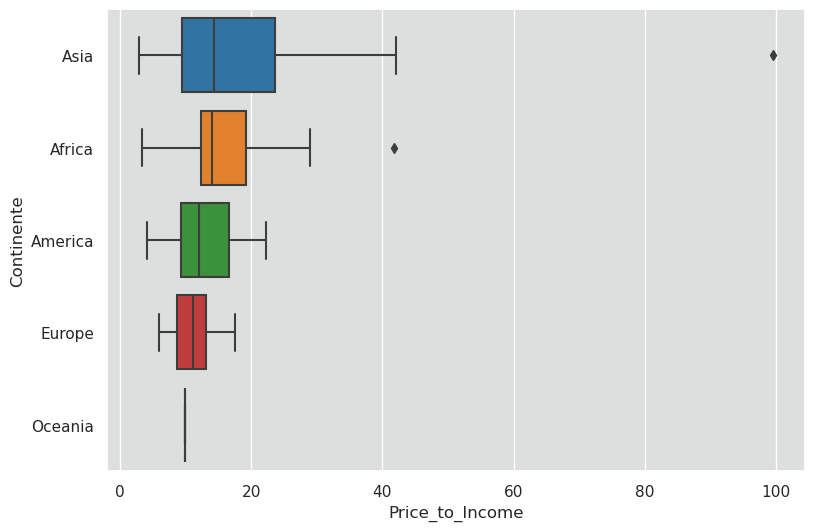

In [23]:
sns.boxplot(
    data = df_prop,
    x = 'Price_to_Income',
    y = 'Continente'
)

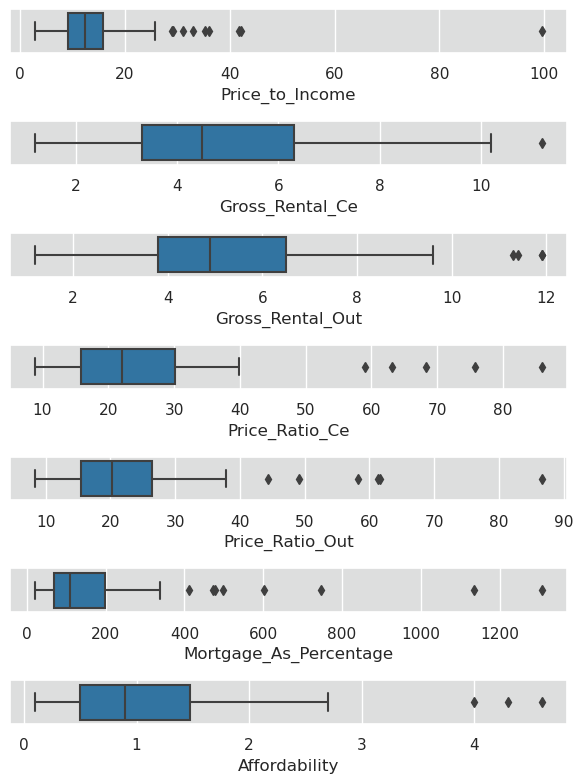

In [24]:
# looking outliers
cols = df_prop.select_dtypes(np.number).columns

fig, ax = plt.subplots(7,figsize = (6,8))


for i, i_col in enumerate(cols):
    sns.boxplot(
        ax = ax[i],
        data = df_prop,
        x = i_col
    )
plt.tight_layout()


In [25]:
def Remove_Outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

## Remove outliers

For educational purposes, the outliers are eliminated so that we can see how they are represented. But in this dataset it is little necessary

In [26]:
outliers = Remove_Outlier(df_prop)

prop = df_prop[outliers]
prop

/tmp/ipykernel_1706/1591930294.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
/tmp/ipykernel_1706/1591930294.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
/tmp/ipykernel_1706/1591930294.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))


,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability,Continente
0,Syria,NaN,2.8,4.2,35.9,24.1,NaN,0.1,Asia
1,Hong Kong (China),NaN,1.7,1.7,NaN,NaN,275.9,0.4,Asia
2,Cameroon,NaN,7.6,9.3,13.1,10.7,NaN,0.1,Africa
3,Nepal,NaN,1.5,2.0,NaN,NaN,NaN,0.2,Asia
4,Sri Lanka,NaN,3.8,2.3,26.0,NaN,NaN,0.2,Asia
...,...,...,...,...,...,...,...,...,...
101,United States,4.2,7.9,9.1,12.7,11.0,38.3,2.6,America
102,United Arab Emirates,3.3,9.7,9.2,10.3,10.8,23.1,NaN,Asia
103,South Africa,3.3,10.2,NaN,9.8,8.9,36.8,2.7,Africa
104,Oman,3.2,6.9,7.6,14.5,13.1,24.8,NaN,Asia


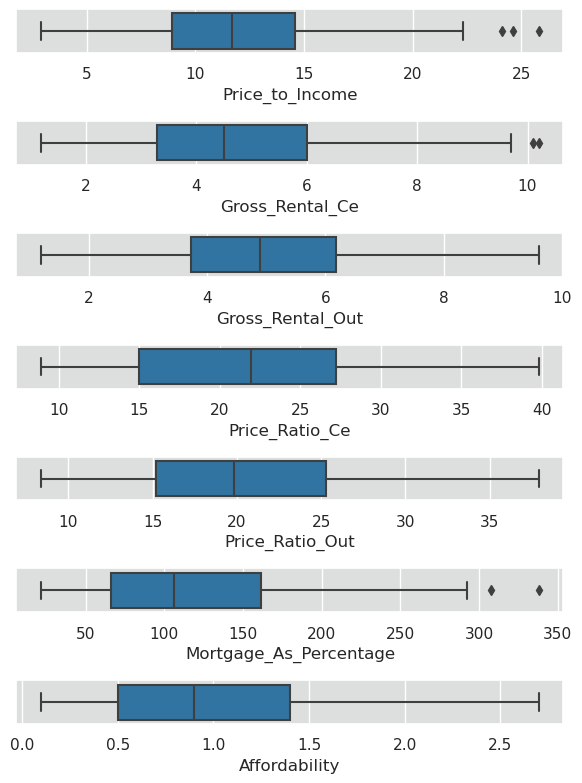

In [27]:
fig, ax = plt.subplots(7,figsize = (6,8))


for i, i_col in enumerate(cols):
    sns.boxplot(
        ax = ax[i],
        data = prop,
        x = i_col
    )
plt.tight_layout()

# Null Values

In [28]:
(
    prop
    .isnull()
    .sum()
)

Country                   0
Price_to_Income           9
Gross_Rental_Ce           1
Gross_Rental_Out          4
Price_Ratio_Ce            5
Price_Ratio_Out           6
Mortgage_As_Percentage    8
Affordability             3
Continente                0
dtype: int64

In [29]:
(
    prop
    .isnull()
    .sum()
    .sum()
)

36

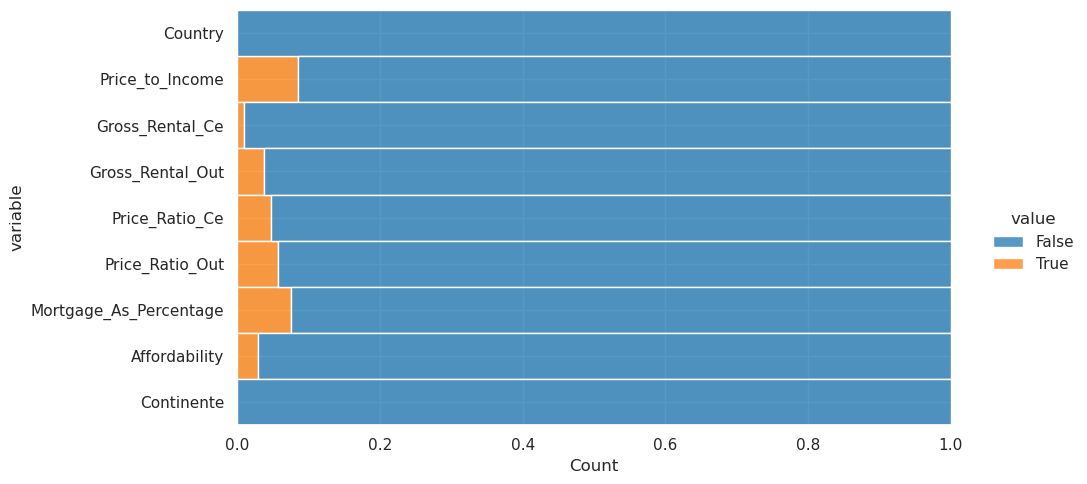

In [30]:
(
    prop
    .isnull()
    .melt()
    .pipe(
        lambda df:(
            sns.displot(
                data = df,
                y = 'variable',
                hue = 'value',
                multiple = 'fill',
                aspect = 2
            )
        )
    )
)

<Axes: >

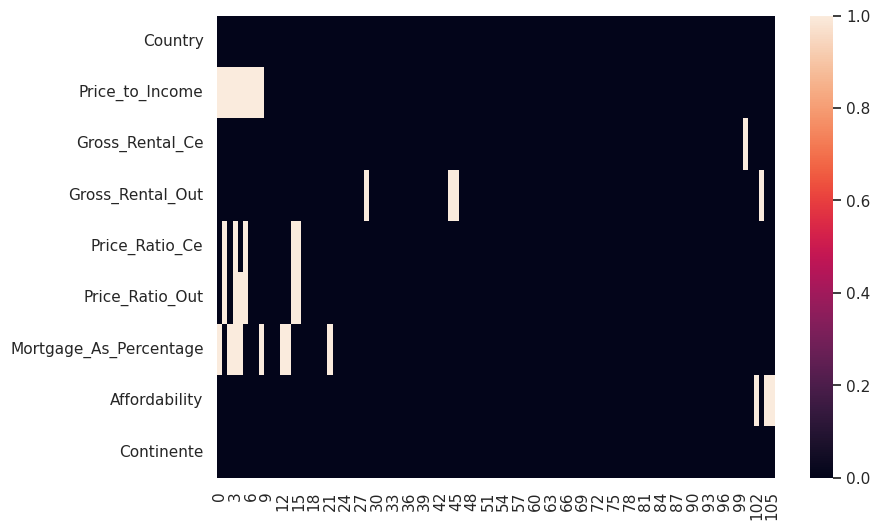

In [31]:
(
    prop
    .isnull()
    .transpose()
    .pipe(
        lambda df:(
            sns.heatmap(
                data = df
            )
        )
    )
)

<Axes: >

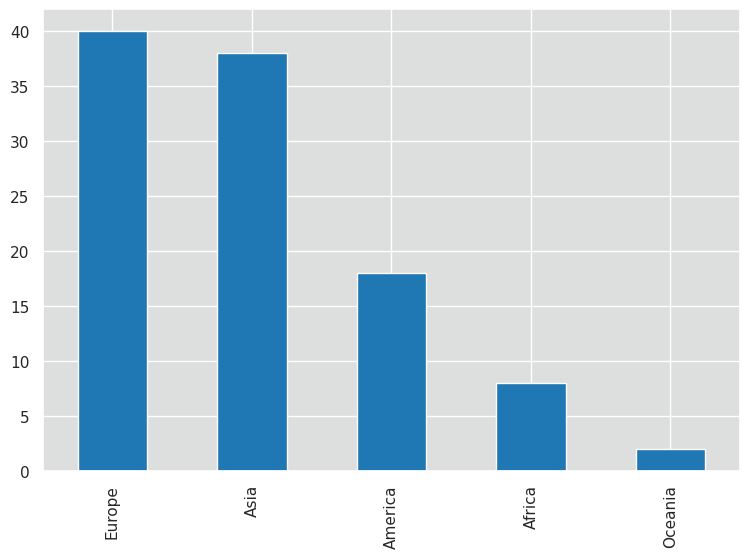

In [32]:
(
    prop['Continente']
    .value_counts()
    .plot(
        kind = 'bar'
    )
)

In Europe there are most outliers

hypothesis
- There are a lot of countries in this contienent
- Europe have a higgert life quality 

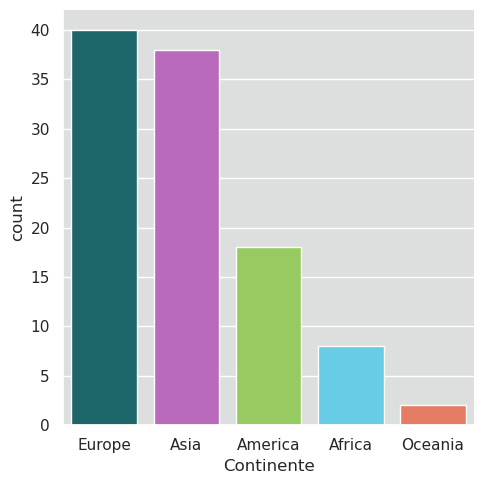

In [33]:
sns.catplot(
    data=prop,
    x='Continente',
    kind='count',
    palette=continent_color,
    order=prop['Continente'].value_counts().index
)

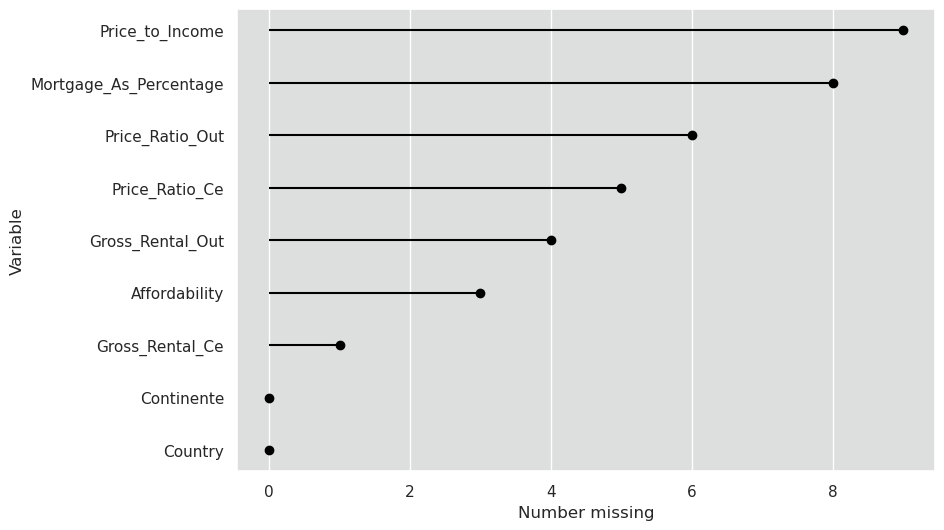

In [34]:
prop.missing.missing_variable_plot()

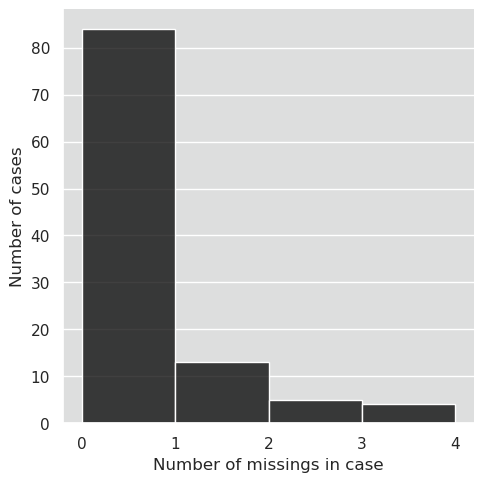

In [35]:
prop.missing.missing_case_plot()

<Axes: >

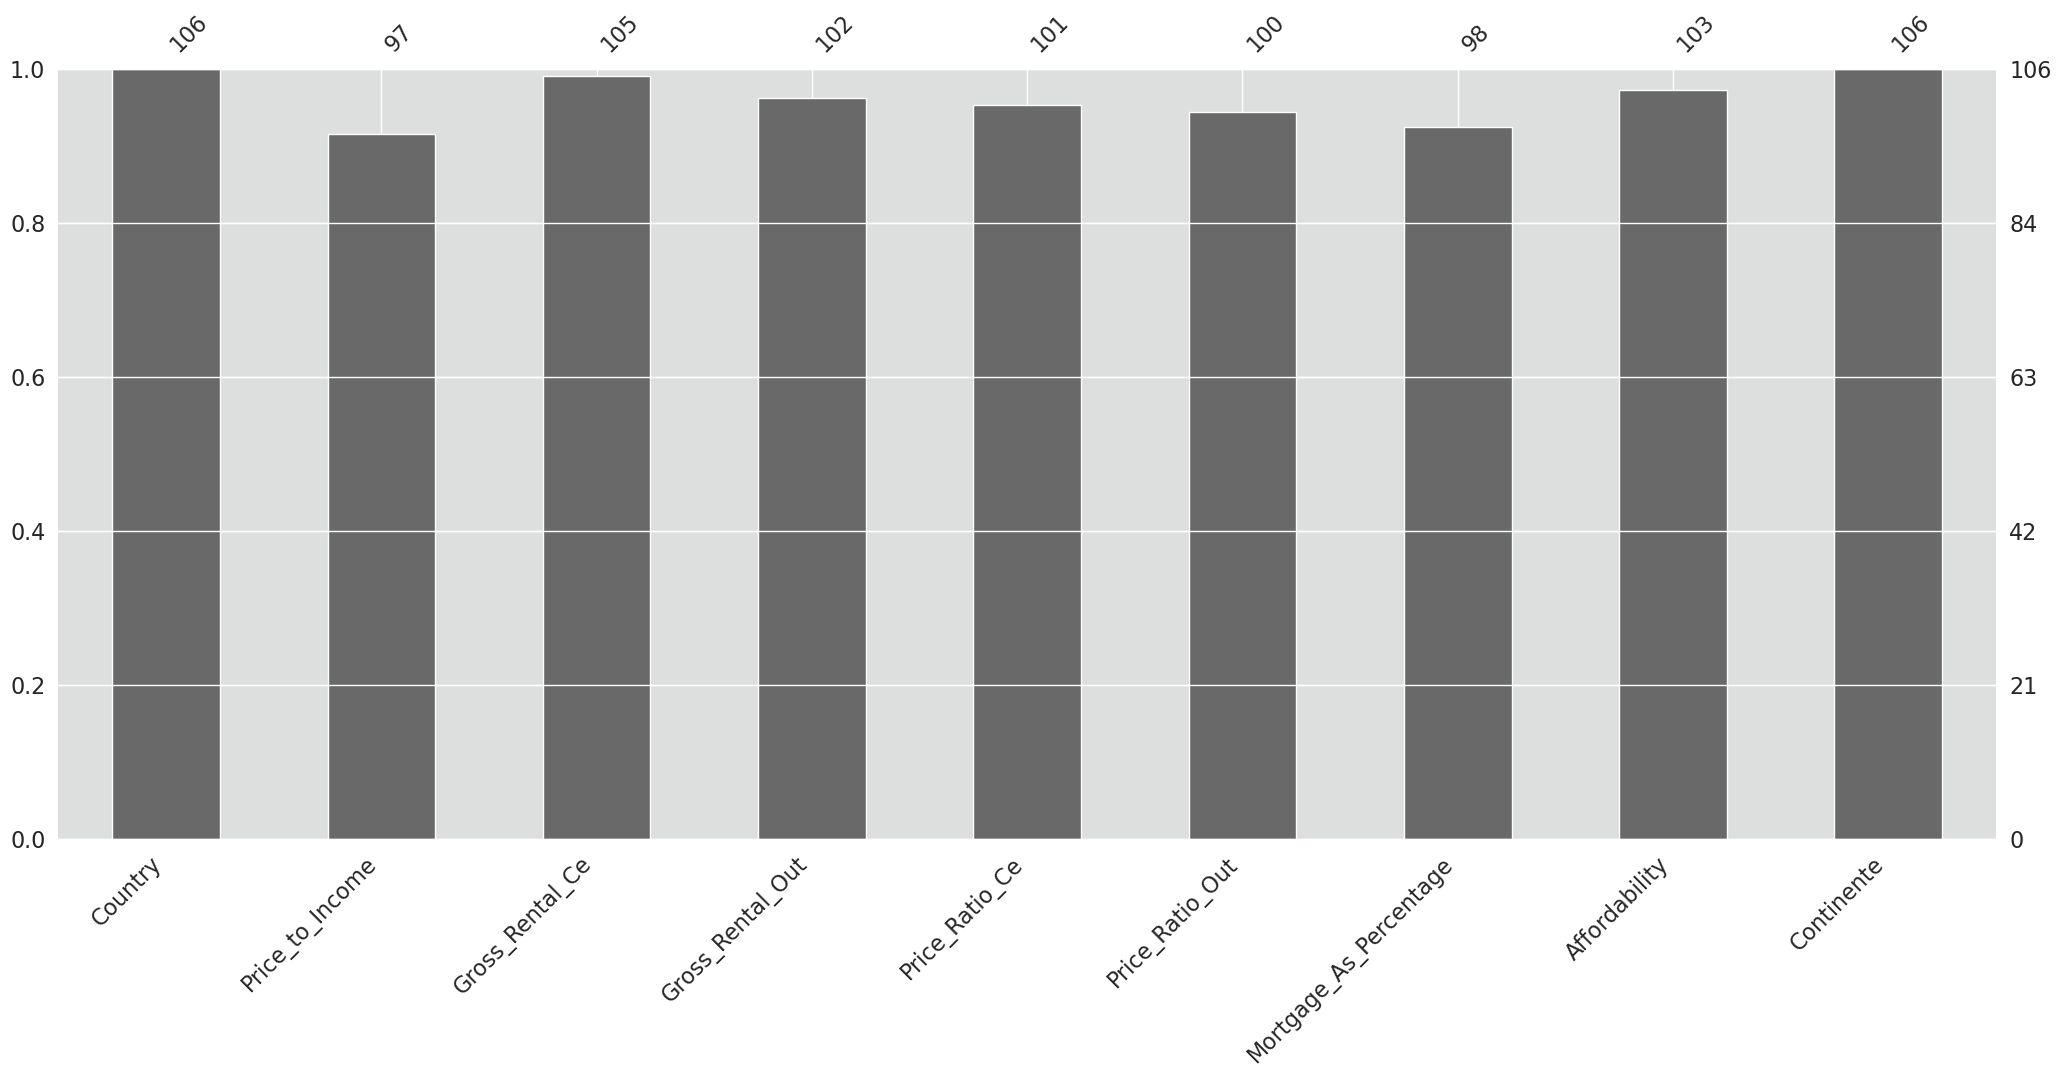

In [36]:
missingno.bar(df = prop)

<Axes: >

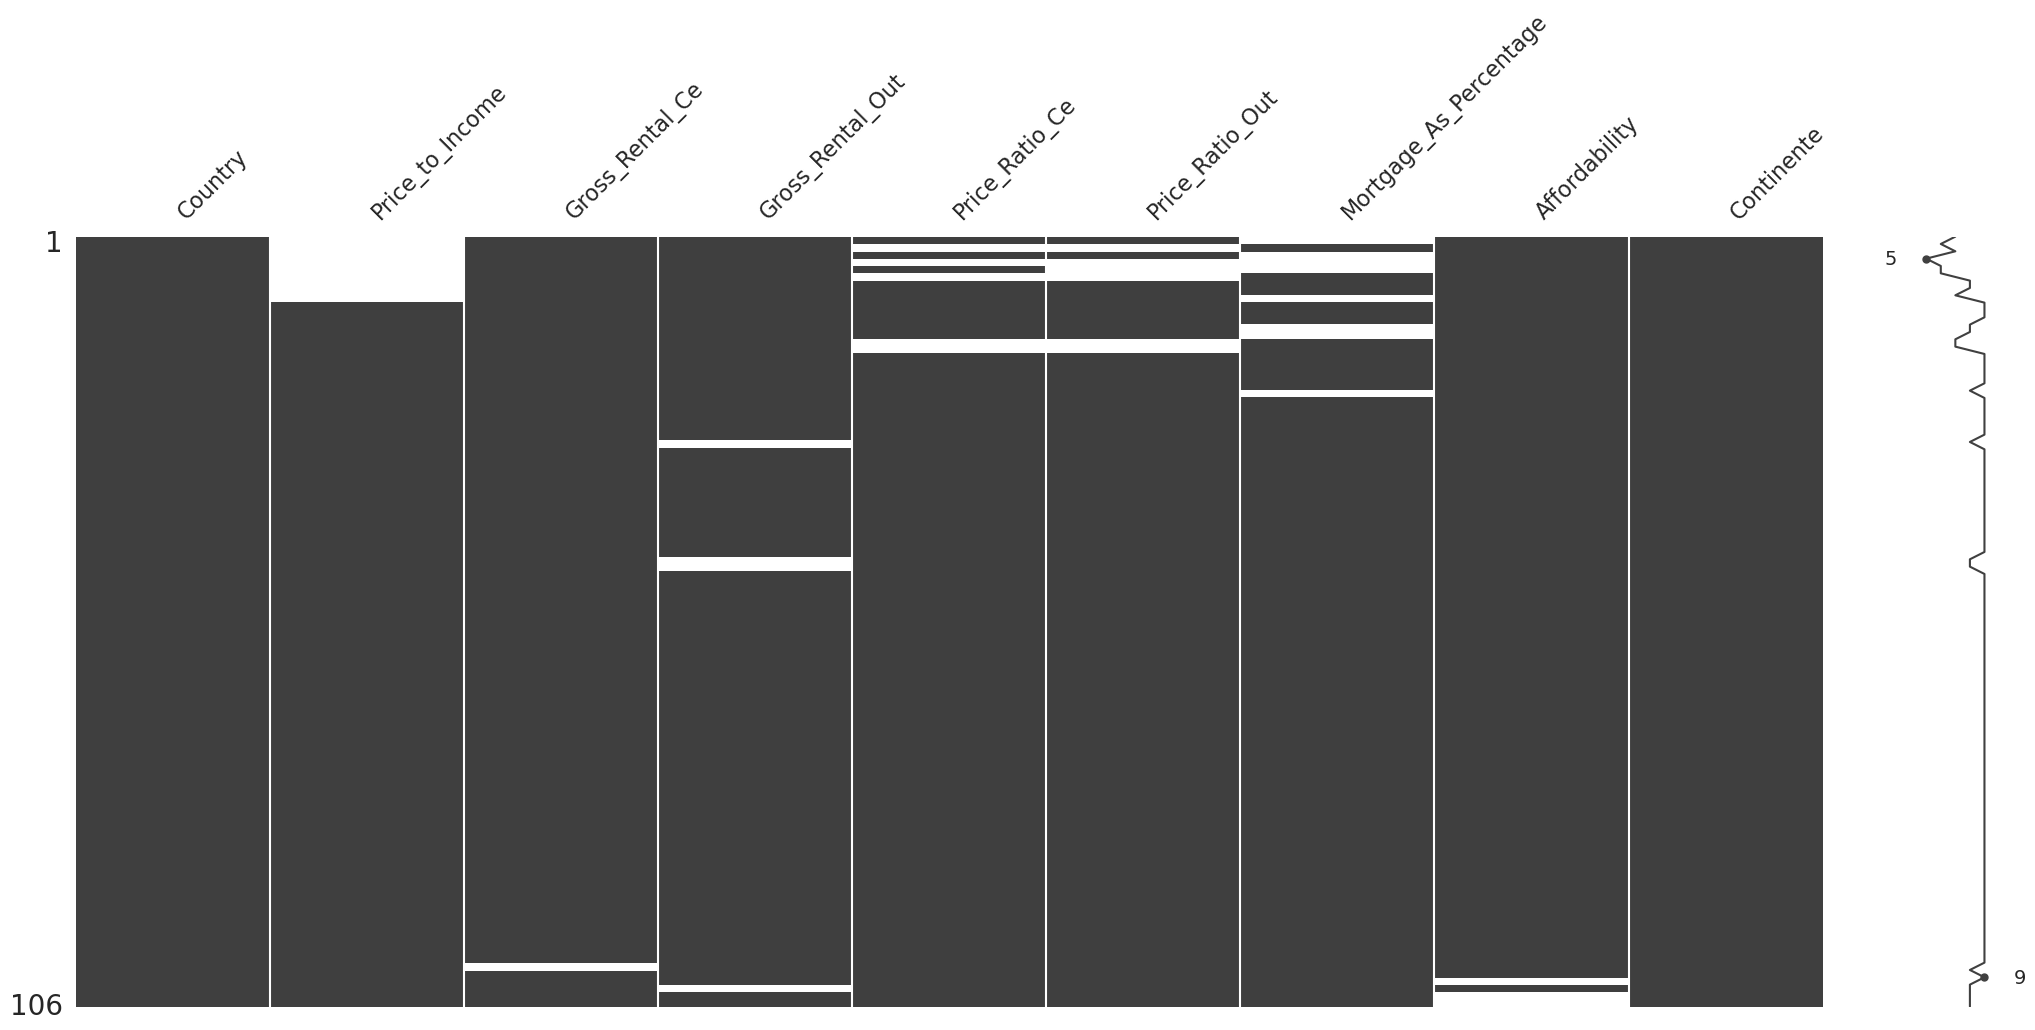

In [37]:
missingno.matrix(df = prop)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

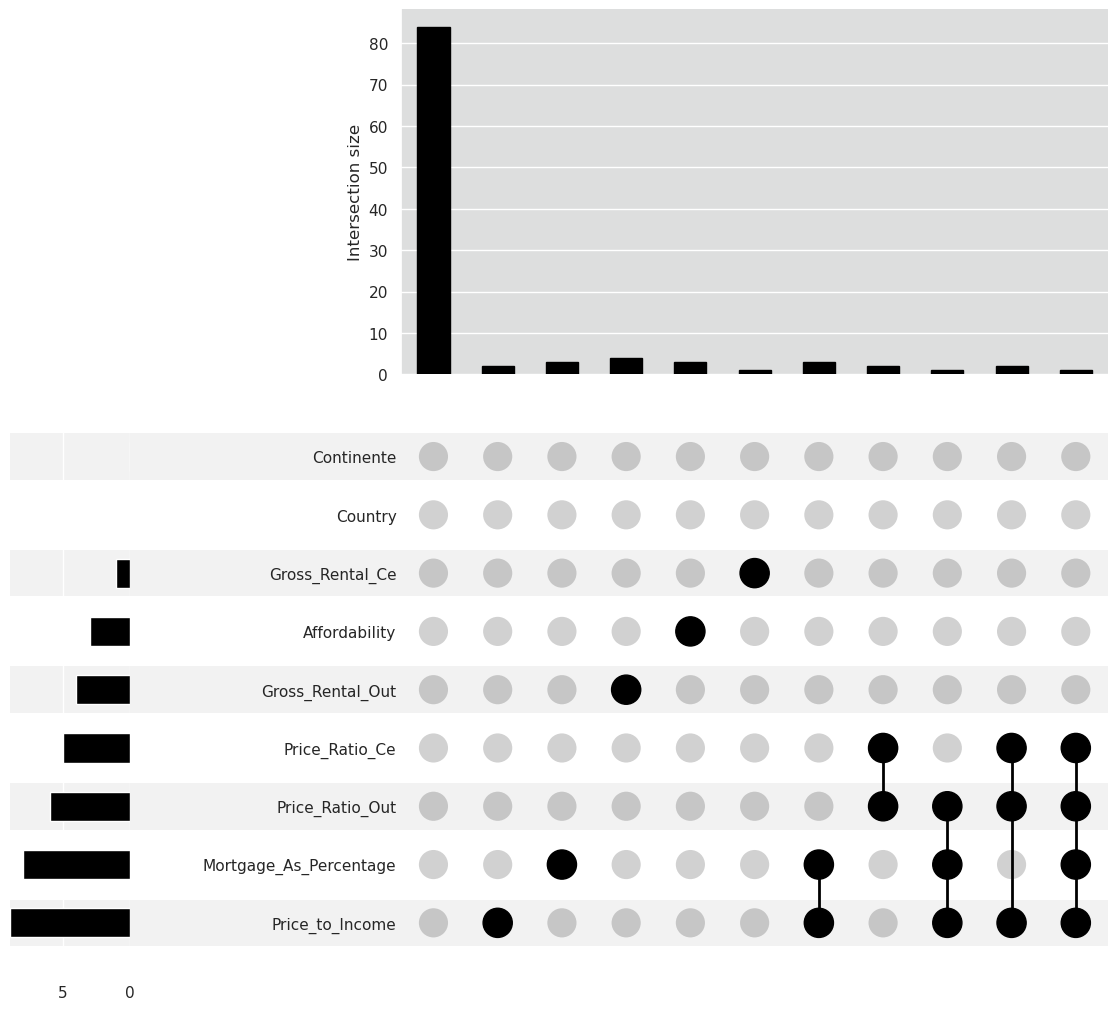

In [38]:
(
    prop
    .missing
    .missing_upsetplot(
        variables=None,
        element_size = 60 
    )
)

Just we did looking outliers into dataset. But in this case we need to look all of these 

# Heatmap

/tmp/ipykernel_1706/3785205057.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mid = np.triu(prop.corr())
/tmp/ipykernel_1706/3785205057.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = df_prop.corr(),
/home/edwlearn/anaconda3/envs/best/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

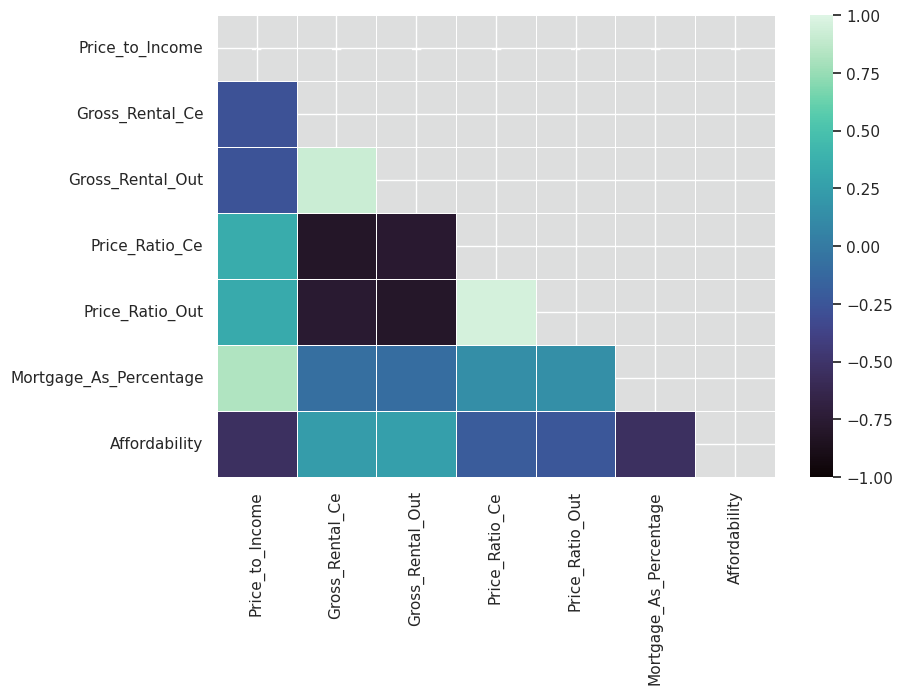

In [39]:
mid = np.triu(prop.corr())

#heatmap
sns.heatmap(
    data = df_prop.corr(),
    cmap = 'mako',
    center = 0,
    vmin = -1,
    vmax = 1,
    linewidths= 0.5,
    mask = mid,
    annot = True,
    fmt = '.2f'  
)

# Correlations

- [ ] ¿Existe alguna relación entre el ratio precio-ingreso y el índice de asequibilidad?


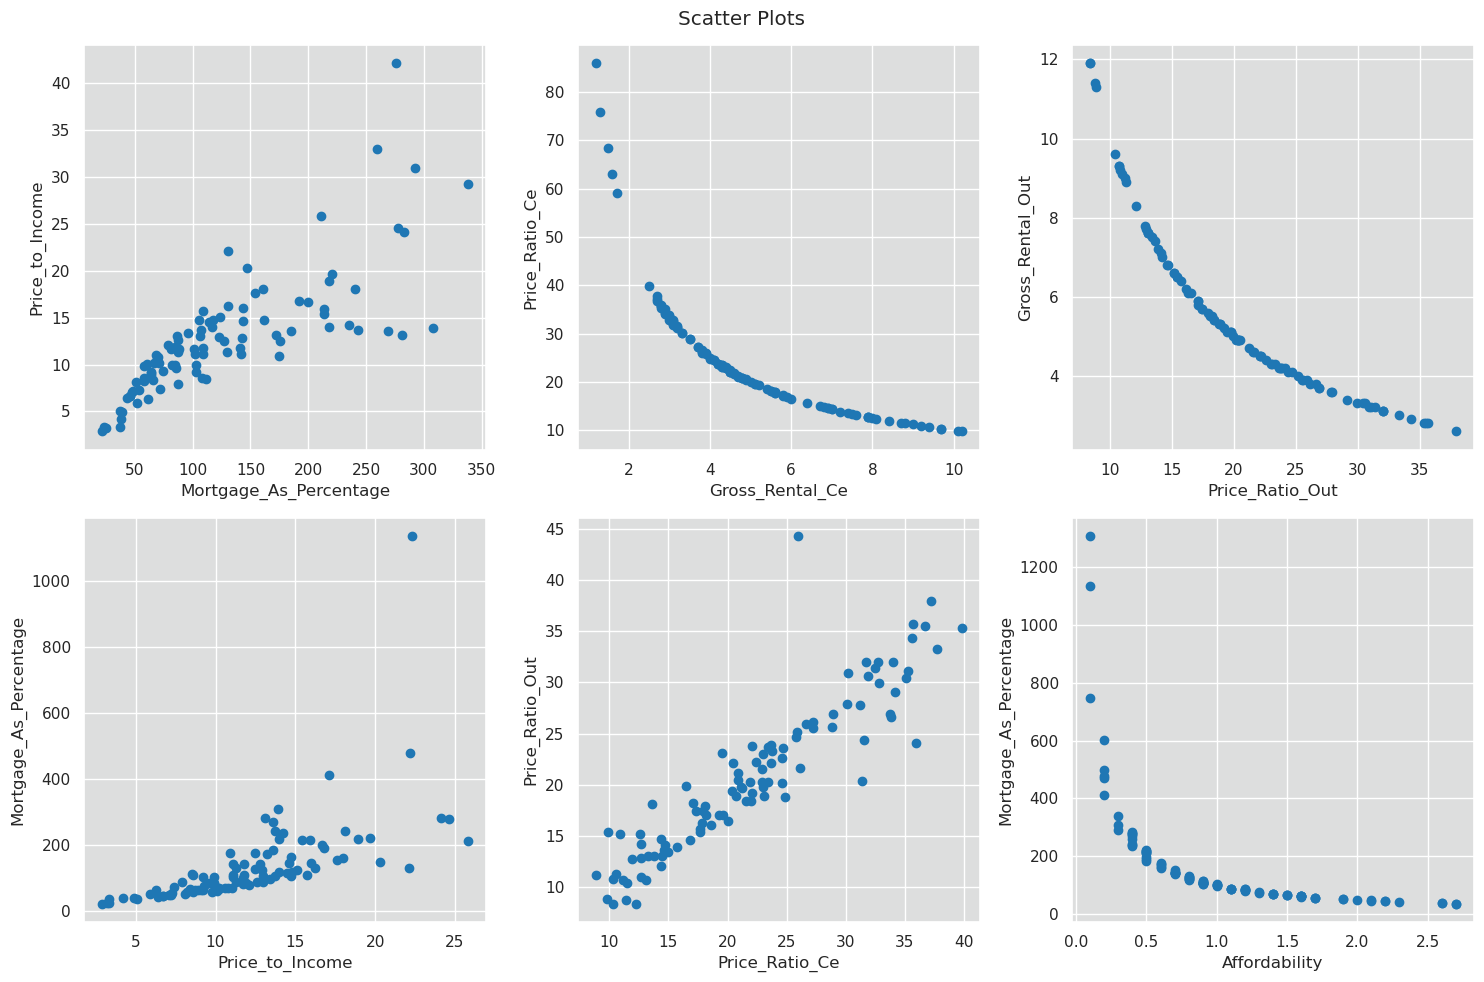

In [40]:
import matplotlib.pyplot as plt

# Define the data to plot
x_values = ['Mortgage_As_Percentage', 'Gross_Rental_Ce', 'Price_Ratio_Out', 'Price_to_Income', 'Price_Ratio_Ce', 'Affordability']
y_values = ['Price_to_Income', 'Price_Ratio_Ce', 'Gross_Rental_Out', 'Mortgage_As_Percentage', 'Price_Ratio_Out', 'Mortgage_As_Percentage']

# Create a figure and axis object
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Iterate over the data and plot each scatter plot
for i, ax in enumerate(axs.flatten()):
    ax.scatter(prop[x_values[i]], df_prop[y_values[i]])
    ax.set_xlabel(x_values[i])
    ax.set_ylabel(y_values[i])

# Set the overall title for the figure
fig.suptitle('Scatter Plots')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


If delete outliers. we can see a strong correlation between this variables

- [ ] ¿Está relacionado el rendimiento bruto de alquiler en el centro de la ciudad con el ratio precio-alquiler en el centro de la ciudad?


We can see that Price_Ratio_Ce and Gross_Rental_Ce is strong correlation. Negative way,  

- [ ] ¿Existe alguna correlación entre el ratio precio-alquiler fuera de la ciudad y el rendimiento bruto de alquiler fuera de la ciudad?


<Axes: xlabel='Price_Ratio_Out', ylabel='Gross_Rental_Out'>

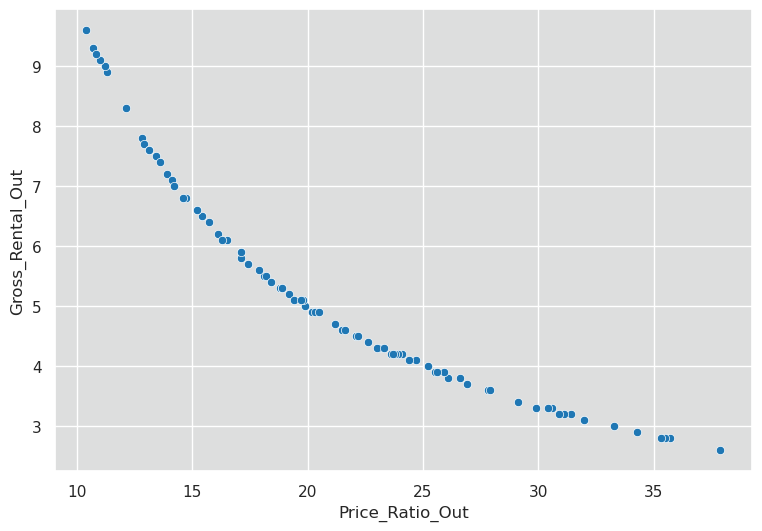

In [41]:
sns.scatterplot(
    data= prop, 
    x= 'Price_Ratio_Out',
    y = 'Gross_Rental_Out',
)

- [ ] ¿Está relacionado el ratio precio-ingreso con el porcentaje de ingresos dedicados a la hipoteca?


<Axes: xlabel='Price_to_Income', ylabel='Mortgage_As_Percentage'>

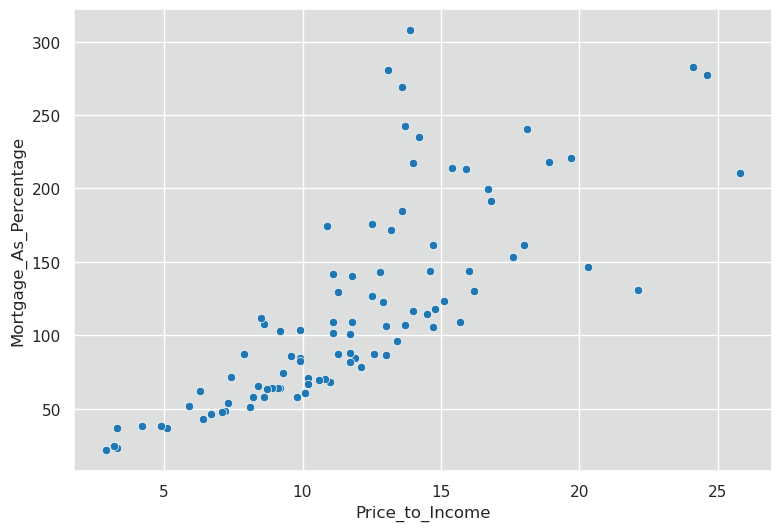

In [42]:
sns.scatterplot(
    data= prop, 
    x= 'Price_to_Income',
    y = 'Mortgage_As_Percentage',
)

- [ ] ¿Hay alguna relación entre el rendimiento bruto de alquiler fuera del centro de la ciudad y el porcentaje de ingresos dedicados a la hipoteca?

<Axes: xlabel='Price_Ratio_Ce', ylabel='Price_Ratio_Out'>

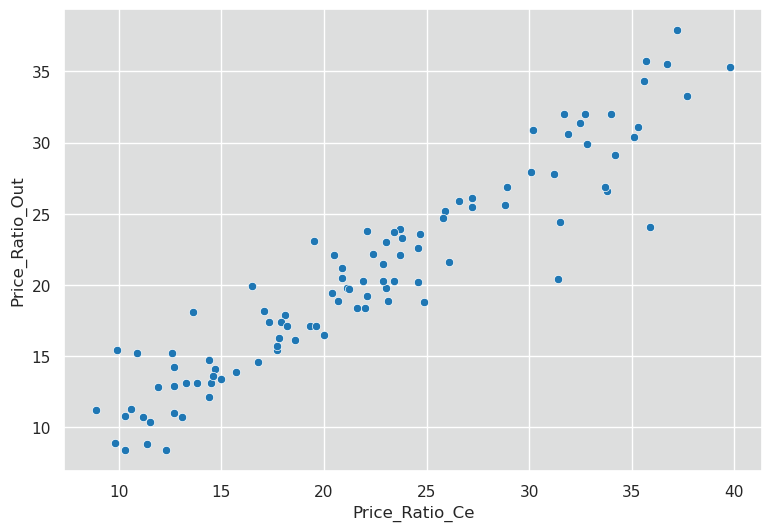

In [43]:
sns.scatterplot(
    data= prop, 
    x= 'Price_Ratio_Ce',
    y = 'Price_Ratio_Out',
)

- [ ] ¿Hay alguna relación entre la proporción de ingresos dedicados a la hipoteca y el índice de asequibilidad en cada país?


In [44]:
prop.columns

Index(['Country', 'Price_to_Income', 'Gross_Rental_Ce', 'Gross_Rental_Out',
       'Price_Ratio_Ce', 'Price_Ratio_Out', 'Mortgage_As_Percentage',
       'Affordability', 'Continente'],
      dtype='object')

<Axes: xlabel='Affordability', ylabel='Mortgage_As_Percentage'>

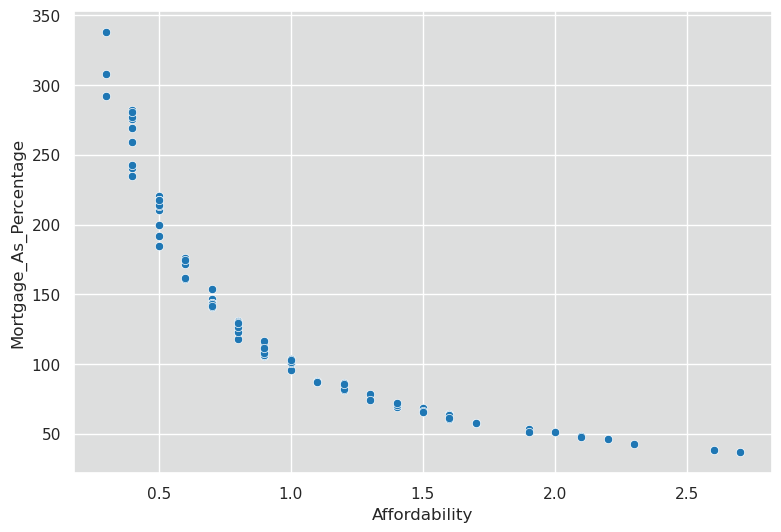

In [45]:
sns.scatterplot(
    data= prop, 
    x= 'Affordability',
    y = 'Mortgage_As_Percentage',
)

## 1 Variable

In [46]:
# making differences between 2 variables to look which of these has more difference

df_prop['Gross_Different'] = round(df_prop['Gross_Rental_Ce'] - df_prop['Gross_Rental_Out'],1) 
df_prop['Price_Ratio_Different'] = round(df_prop['Price_Ratio_Ce'] - df_prop['Price_Ratio_Out'],1)

In [47]:
# Divide continents

df_america = df_prop[df_prop['Continente'] == 'America']
df_europe = df_prop[df_prop['Continente'] == 'Europe']
df_asia = df_prop[df_prop['Continente'] == 'Asia']
df_oceania = df_prop[df_prop['Continente'] == 'Oceania']
df_africa = df_prop[df_prop['Continente'] == 'Africa']

- [ ] 
¿Hay alguna diferencia en el ratio precio-alquiler en el centro de la ciudad en comparación con el ratio precio-alquiler fuera de la ciudad en cada país?

/tmp/ipykernel_1706/1711561656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  difference['Difference'] =  round(difference['Gross_Rental_Out'] - difference['Gross_Rental_Ce'], 1)


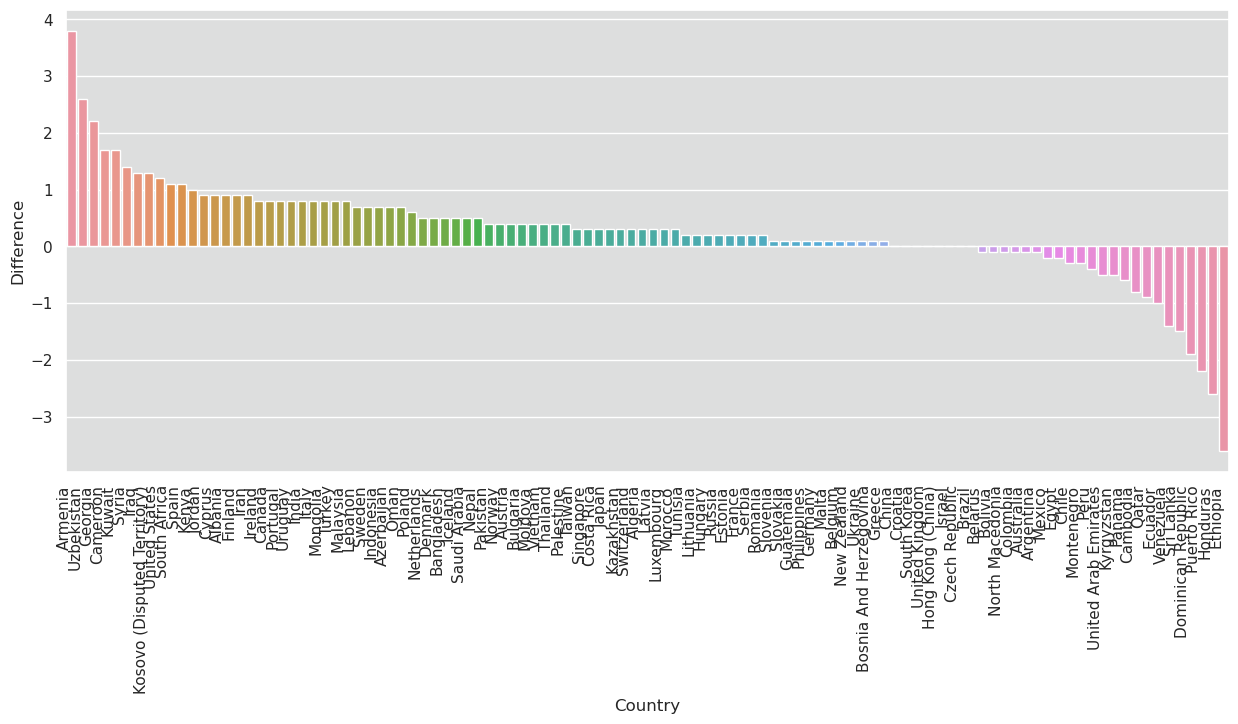

In [48]:
difference = df_prop[['Country', 'Gross_Rental_Ce', 'Gross_Rental_Out', 'Continente']]
difference['Difference'] =  round(difference['Gross_Rental_Out'] - difference['Gross_Rental_Ce'], 1)
difference= difference.sort_values('Difference',ascending=False)

fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(
    data = difference,
    x = 'Country',
    y = 'Difference',
    ax = ax
    
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

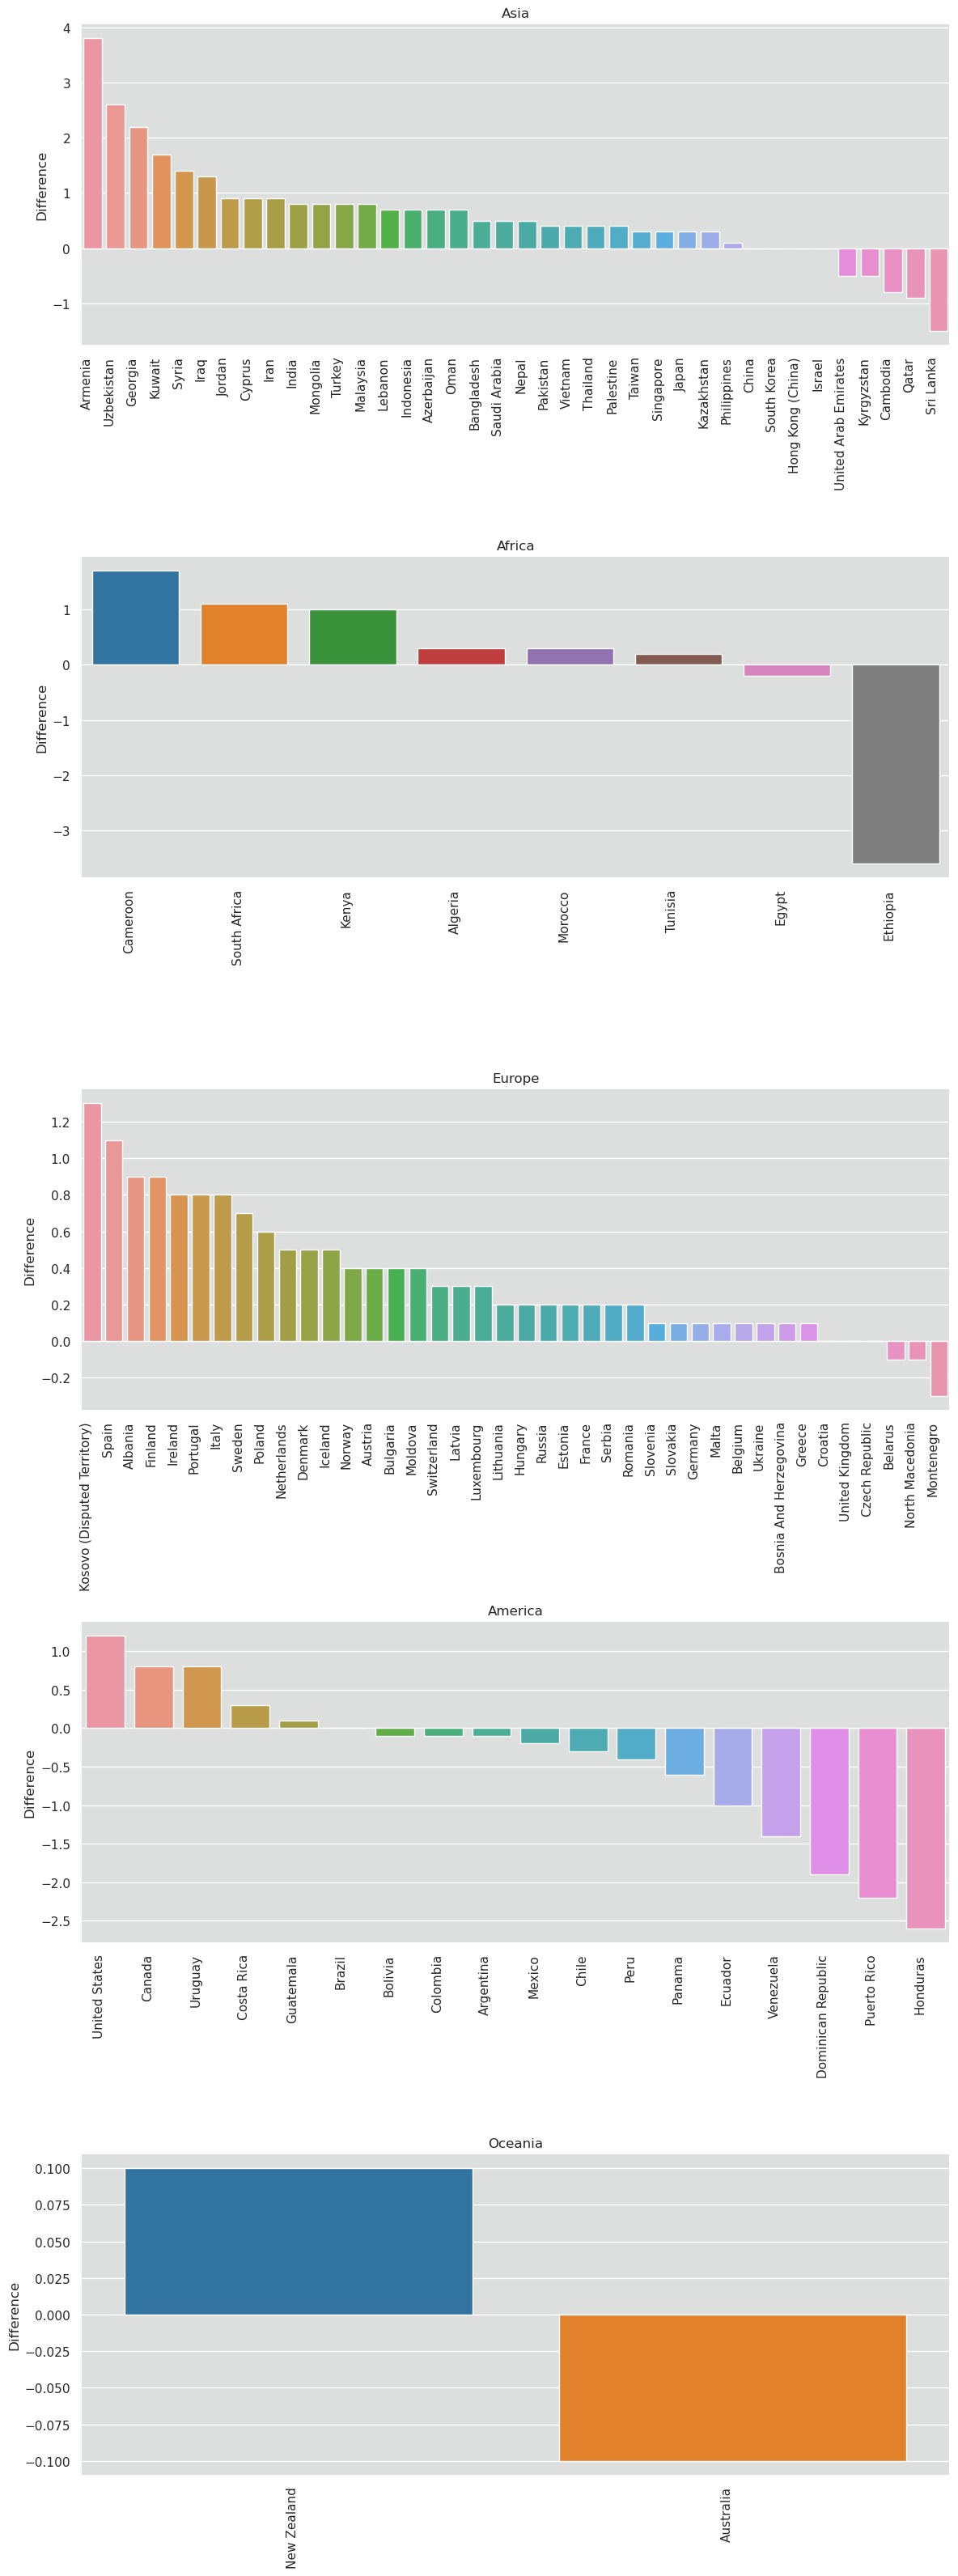

In [49]:
continents = list(difference['Continente'].unique())
continents

fig, ax = plt.subplots(5, figsize = (12, 32))

for i, i_col in enumerate(continents):
    sns.barplot(
        ax=ax[i],
        data=difference[difference['Continente'] == f'{i_col}'],
        x='Country',
        y='Difference'
    )
    ax[i].set_xlabel('')  # Remove x-label
    ax[i].set_title(f'{i_col}')

for j, j_col in enumerate(continents):
    ax[j].set_title(f'{j_col}')    

for i, i_col in enumerate(continents):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, horizontalalignment='right')

plt.tight_layout()
plt.show()

- [ ] ¿Cuál es el continente con el mayor ratio precio-ingreso promedio y el mayor rendimiento bruto de alquiler en el centro de la ciudad?


<Axes: xlabel='Continente', ylabel='Price_to_Income'>

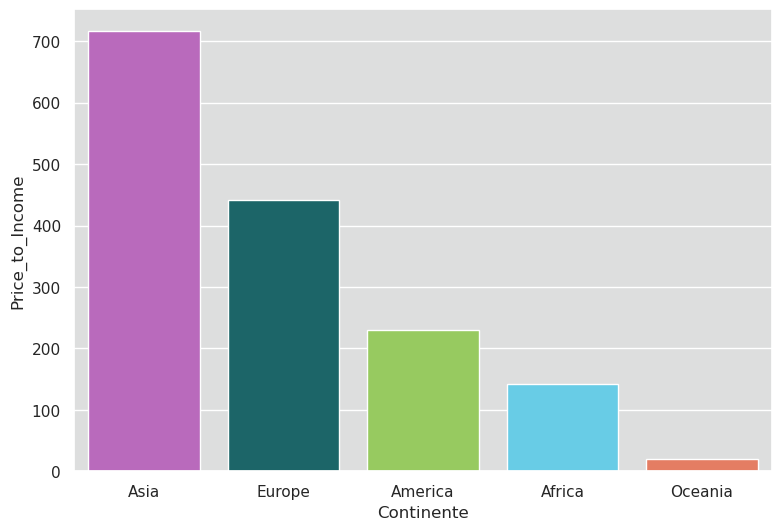

In [50]:
price_inc =df_prop.groupby('Continente')[['Price_to_Income','Gross_Rental_Ce']].sum()

price_inc.sort_values('Price_to_Income', ascending= False, inplace=True)

price_inc.reset_index(inplace=True)

sns.barplot(
    data = price_inc,
    x = 'Continente',
    y = 'Price_to_Income',
    palette= continent_color
)


- [ ] ¿Qué continente tiene el mayor ratio precio-ingreso y el mayor porcentaje de ingresos dedicados a la hipoteca?


- [ ] ¿Qué continente tiene el mayor rendimiento bruto de alquiler fuera del centro de la ciudad y el mayor ratio precio-alquiler fuera de la ciudad?


- [ ] ¿Cuál es el continente con el índice de asequibilidad más bajo y el mayor ratio precio-alquiler fuera de la ciudad?


<Axes: xlabel='Continente', ylabel='Mortgage_As_Percentage'>

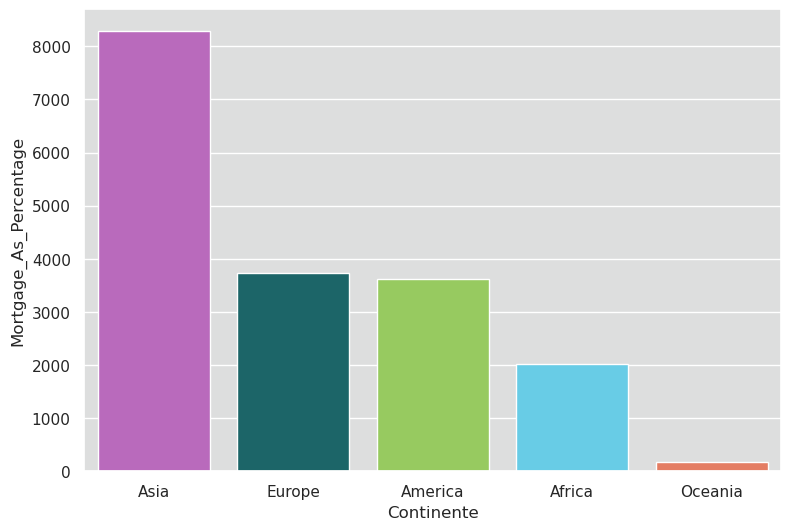

In [51]:
mortgage = df_prop.groupby(['Continente'])['Mortgage_As_Percentage'].sum()
mortgage = pd.DataFrame(mortgage)
mortgage.reset_index(inplace=True) 

sns.barplot(
    data = mortgage,
    x = 'Continente',
    y = 'Mortgage_As_Percentage',
    palette= continent_color,
    order = mortgage.sort_values('Mortgage_As_Percentage', ascending = False).Continente
)

- [ ] ¿Cuál es el continente con el mayor rendimiento bruto de alquiler en el centro de la ciudad y el mayor rendimiento bruto de alquiler fuera del centro de la ciudad?


In [52]:
df_prop.columns

Index(['Country', 'Price_to_Income', 'Gross_Rental_Ce', 'Gross_Rental_Out',
       'Price_Ratio_Ce', 'Price_Ratio_Out', 'Mortgage_As_Percentage',
       'Affordability', 'Continente', 'Gross_Different',
       'Price_Ratio_Different'],
      dtype='object')

In [53]:
gross = df_prop.groupby('Continente')[['Gross_Rental_Ce','Gross_Rental_Out']].sum()

gross.reset_index(inplace = True)
gross.sort_values('Gross_Rental_Ce', ascending=False)

,Continente,Gross_Rental_Ce,Gross_Rental_Out
2,Asia,193.2,215.1
3,Europe,164.4,178.0
1,America,115.6,107.9
0,Africa,52.0,52.8
4,Oceania,8.1,8.1


- [ ] 
¿Qué continente tiene la mayor diferencia en el rendimiento bruto de alquiler entre el centro de la ciudad y fuera de la ciudad?


- [ ] ¿Qué continente tiene la mayor proporción de ingresos dedicados a la hipoteca? ¿Cómo se compara con otros continentes?


- [ ] ¿Cómo se compara el rendimiento bruto de alquiler en países con diferentes ratios precio-ingreso?

In [54]:
df_america.sort_values('Price_to_Income', ascending= True)

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability,Continente,Gross_Different,Price_Ratio_Different
101,United States,4.2,7.9,9.1,12.7,11.0,38.3,2.6,America,-1.2,1.7
100,Puerto Rico,4.9,11.2,9.0,8.9,11.2,38.5,2.6,America,2.2,-2.3
85,Honduras,8.5,9.2,6.6,10.9,15.2,111.5,0.9,America,2.6,-4.3
84,Mexico,8.6,7.9,7.7,12.7,12.9,107.7,0.9,America,0.2,-0.2
79,Costa Rica,9.2,6.8,7.1,14.7,14.1,102.8,1.0,America,-0.3,0.6
76,Canada,9.6,3.8,4.6,26.1,21.6,85.8,1.2,America,-0.8,4.5
64,Uruguay,11.1,4.6,5.4,21.6,18.4,108.9,0.9,America,-0.8,3.2
61,Ecuador,11.3,6.0,5.0,16.5,19.9,129.4,0.8,America,1.0,-3.4
59,Panama,11.7,8.4,7.8,11.9,12.8,100.8,1.0,America,0.6,-0.9
51,Guatemala,12.5,7.5,7.6,13.3,13.1,126.8,0.8,America,-0.1,0.2


In [55]:
df_europe.sort_values('Price_to_Income', ascending= True)

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability,Continente,Gross_Different,Price_Ratio_Different
98,Iceland,5.9,5.6,6.1,17.8,16.3,51.5,1.9,Europe,-0.5,1.5
96,Belgium,6.4,4.8,4.9,20.9,20.5,42.9,2.3,Europe,-0.1,0.4
94,Netherlands,6.7,4.8,5.3,20.7,18.9,46.2,2.2,Europe,-0.5,1.8
95,Denmark,6.7,4.4,4.9,22.9,20.3,46.2,2.2,Europe,-0.5,2.6
93,Spain,7.1,5.0,6.1,20.0,16.5,47.4,2.1,Europe,-1.1,3.5
91,Ireland,7.3,6.7,7.5,15.0,13.4,53.7,1.9,Europe,-0.8,1.6
88,Finland,8.1,3.2,4.1,31.5,24.4,51.1,2.0,Europe,-0.9,7.1
87,Norway,8.2,3.5,3.9,28.8,25.6,57.8,1.7,Europe,-0.4,3.2
86,United Kingdom,8.4,4.5,4.5,22.4,22.2,65.7,1.5,Europe,0.0,0.2
83,Latvia,8.6,4.2,4.5,23.7,22.1,57.8,1.7,Europe,-0.3,1.6


In [56]:
df_asia.sort_values('Price_to_Income', ascending= True)

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability,Continente,Gross_Different,Price_Ratio_Different
105,Saudi Arabia,2.9,6.9,7.4,14.6,13.6,21.8,4.6,Asia,-0.5,1.0
104,Oman,3.2,6.9,7.6,14.5,13.1,24.8,4.0,Asia,-0.7,1.4
102,United Arab Emirates,3.3,9.7,9.2,10.3,10.8,23.1,4.3,Asia,0.5,-0.5
99,Qatar,5.1,7.9,7.0,12.7,14.2,36.8,2.7,Asia,0.9,-1.5
97,Palestine,6.3,7.2,7.6,13.8,13.1,61.7,1.6,Asia,-0.4,0.7
92,Cyprus,7.2,8.7,9.6,11.5,10.4,48.4,2.1,Asia,-0.9,1.1
90,Jordan,7.4,5.9,6.8,16.8,14.6,71.8,1.4,Asia,-0.9,2.2
89,Iraq,7.9,7.0,8.3,14.4,12.1,87.2,1.1,Asia,-1.3,2.3
81,Malaysia,8.9,4.3,5.1,23.0,19.8,63.8,1.6,Asia,-0.8,3.2
77,Kuwait,9.3,3.2,4.9,31.4,20.4,74.2,1.3,Asia,-1.7,11.0


In [57]:
df_africa.sort_values('Price_to_Income', ascending= True)

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability,Continente,Gross_Different,Price_Ratio_Different
103,South Africa,3.3,10.2,11.3,9.8,8.9,36.8,2.7,Africa,-1.1,0.9
55,Tunisia,11.8,4.9,5.1,20.4,19.4,140.6,0.7,Africa,-0.2,1.0
52,Egypt,12.5,7.0,6.8,14.4,14.7,175.8,0.6,Africa,0.2,-0.3
42,Kenya,13.6,4.3,5.3,23.1,18.9,184.9,0.5,Africa,-1.0,4.2
34,Morocco,14.5,4.6,4.9,21.9,20.3,114.4,0.9,Africa,-0.3,1.6
25,Algeria,16.0,3.3,3.6,30.1,27.9,143.9,0.7,Africa,-0.3,2.2
8,Ethiopia,28.9,10.1,6.5,9.9,15.4,471.8,0.2,Africa,3.6,-5.5
2,Cameroon,41.7,7.6,9.3,13.1,10.7,747.9,0.1,Africa,-1.7,2.4


## Mejores paises para Comprar en el centro de la ciudad Por continente

In [58]:
df_america[['Country','Price_Ratio_Ce']].sort_values('Price_Ratio_Ce', ascending=False)

,Country,Price_Ratio_Ce
12,Argentina,37.2
76,Canada,26.1
22,Brazil,23.7
24,Chile,22.1
64,Uruguay,21.6
18,Colombia,20.9
17,Peru,20.5
48,Bolivia,17.3
61,Ecuador,16.5
79,Costa Rica,14.7


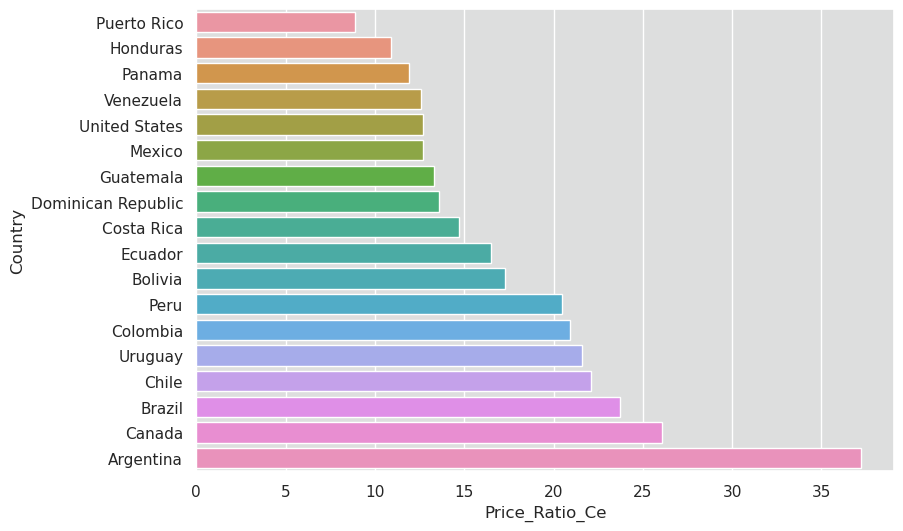

In [59]:
fig, ax = plt.subplots()

sns.barplot(
    data = df_america,
    y = 'Country',
    x = 'Price_Ratio_Ce',
    order = df_america.sort_values('Price_Ratio_Ce', ascending = True).Country,
    ax = ax
)

#ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Europe

In [60]:
df_europe[['Country','Price_Ratio_Ce']].sort_values('Price_Ratio_Ce', ascending=True)

,Country,Price_Ratio_Ce
91,Ireland,15.0
47,Montenegro,17.1
54,Portugal,17.7
98,Iceland,17.8
60,Malta,17.9
35,Ukraine,18.1
63,Moldova,18.2
93,Spain,20.0
94,Netherlands,20.7
96,Belgium,20.9


<Axes: xlabel='Price_Ratio_Ce', ylabel='Country'>

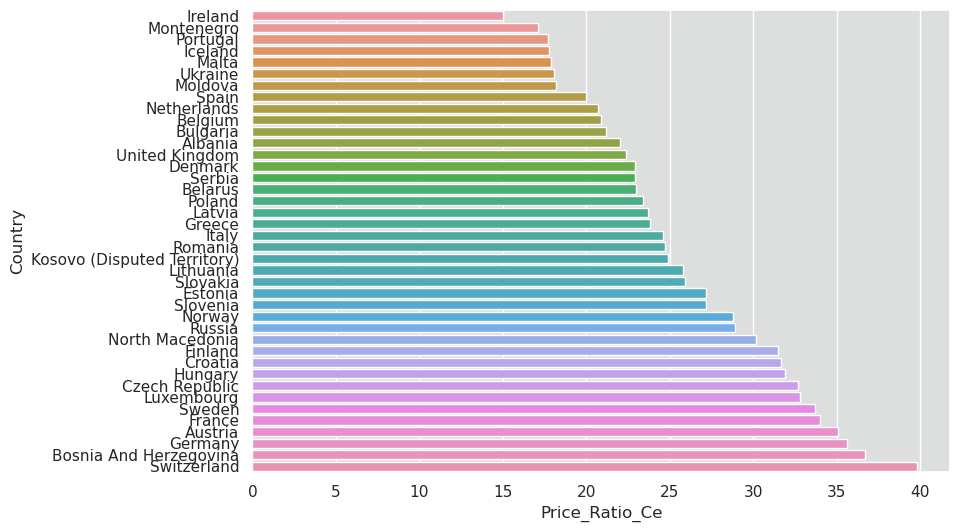

In [61]:
sns.barplot(
    df_europe,
    x = 'Price_Ratio_Ce',
    y = 'Country',
    order = df_europe.sort_values('Price_Ratio_Ce', ascending=True).Country
)

In [62]:
df_europe[['Country','Price_Ratio_Ce', 'Price_Ratio_Out', 'Price_Ratio_Different']]

,Country,Price_Ratio_Ce,Price_Ratio_Out,Price_Ratio_Different
20,Serbia,22.9,21.5,1.4
23,Russia,28.9,26.9,2.0
29,Kosovo (Disputed Territory),24.9,18.8,6.1
30,Albania,22.0,18.4,3.6
33,Hungary,31.9,30.6,1.3
35,Ukraine,18.1,17.9,0.2
36,Czech Republic,32.7,32.0,0.7
40,North Macedonia,30.2,30.9,-0.7
41,Belarus,23.0,23.0,0.0
43,Croatia,31.7,32.0,-0.3


## Asia

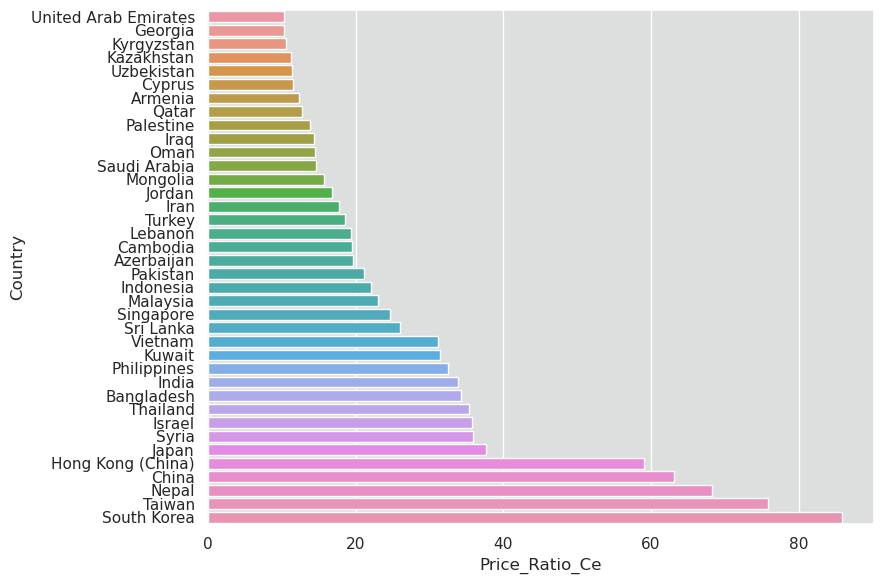

In [63]:
sns.barplot(
    df_asia,
    x = 'Price_Ratio_Ce',
    y = 'Country',
    order = df_asia.sort_values('Price_Ratio_Ce', ascending=True).Country
)
plt.tight_layout()

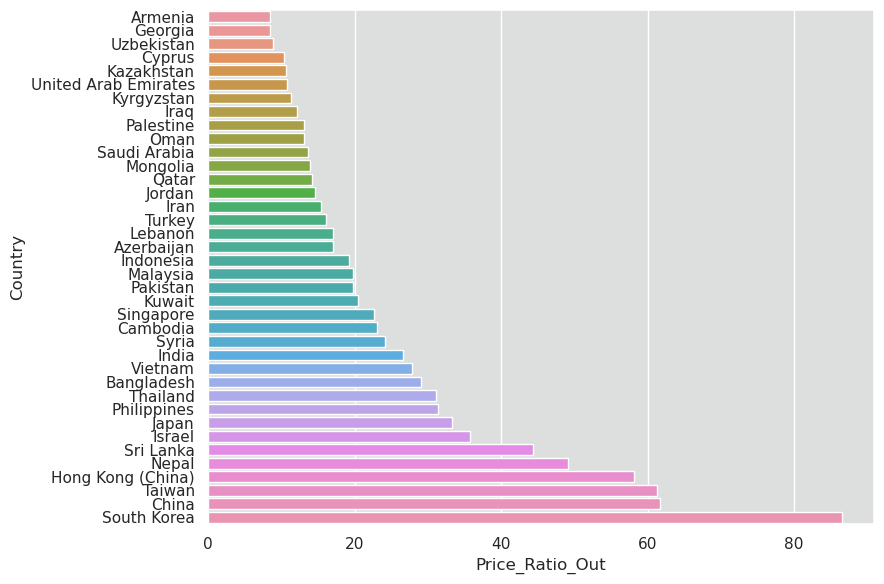

In [64]:
sns.barplot(
    df_asia,
    x = 'Price_Ratio_Out',
    y = 'Country',
    order = df_asia.sort_values('Price_Ratio_Out', ascending=True).Country
)
plt.tight_layout()

## Africa

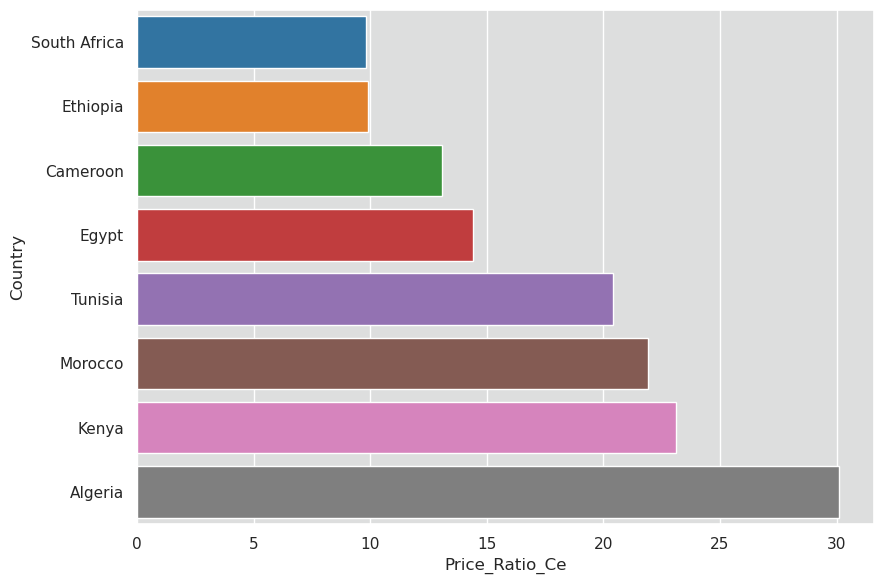

In [65]:
sns.barplot(
    df_africa,
    x = 'Price_Ratio_Ce',
    y = 'Country',
    order = df_africa.sort_values('Price_Ratio_Ce', ascending=True).Country
)
plt.tight_layout()

# Buy Inside and outside of the city

## Asia

In [66]:
centro = df_asia.sort_values('Price_Ratio_Ce', ascending=True).head(5)
fuera = df_asia.sort_values('Price_Ratio_Out', ascending=True).head(5)

centro[centro.isin(fuera)].dropna()

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability,Continente,Gross_Different,Price_Ratio_Different
44,Georgia,13.2,9.7,11.9,10.3,8.4,172.0,0.6,Asia,-2.2,1.9
66,Kazakhstan,10.9,9.0,9.3,11.2,10.7,174.6,0.6,Asia,-0.3,0.5
45,Uzbekistan,13.1,8.8,11.4,11.4,8.8,280.9,0.4,Asia,-2.6,2.6


## America

In [67]:
centro = df_america.sort_values('Price_Ratio_Ce', ascending=True).head(10)
fuera = df_america.sort_values('Price_Ratio_Out', ascending=True).head(10)

centro[centro.isin(fuera)].dropna()

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability,Continente,Gross_Different,Price_Ratio_Different
100,Puerto Rico,4.9,11.2,9.0,8.9,11.2,38.5,2.6,America,2.2,-2.3
85,Honduras,8.5,9.2,6.6,10.9,15.2,111.5,0.9,America,2.6,-4.3
59,Panama,11.7,8.4,7.8,11.9,12.8,100.8,1.0,America,0.6,-0.9
21,Venezuela,17.1,8.0,6.6,12.6,15.2,411.9,0.2,America,1.4,-2.6
101,United States,4.2,7.9,9.1,12.7,11.0,38.3,2.6,America,-1.2,1.7
84,Mexico,8.6,7.9,7.7,12.7,12.9,107.7,0.9,America,0.2,-0.2
51,Guatemala,12.5,7.5,7.6,13.3,13.1,126.8,0.8,America,-0.1,0.2
26,Dominican Republic,15.9,7.4,5.5,13.6,18.1,213.4,0.5,America,1.9,-4.5
79,Costa Rica,9.2,6.8,7.1,14.7,14.1,102.8,1.0,America,-0.3,0.6


## Europa

In [68]:
centro = df_europe.sort_values('Price_Ratio_Ce', ascending=True).head(10)
fuera = df_europe.sort_values('Price_Ratio_Out', ascending=True).head(10)

centro[centro.isin(fuera)].dropna()

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability,Continente,Gross_Different,Price_Ratio_Different
91,Ireland,7.3,6.7,7.5,15.0,13.4,53.7,1.9,Europe,-0.8,1.6
47,Montenegro,13.0,5.8,5.5,17.1,18.2,106.3,0.9,Europe,0.3,-1.1
54,Portugal,11.9,5.6,6.4,17.7,15.7,84.6,1.2,Europe,-0.8,2.0
98,Iceland,5.9,5.6,6.1,17.8,16.3,51.5,1.9,Europe,-0.5,1.5
60,Malta,11.3,5.6,5.7,17.9,17.4,87.4,1.1,Europe,-0.1,0.5
35,Ukraine,14.2,5.5,5.6,18.1,17.9,234.9,0.4,Europe,-0.1,0.2
63,Moldova,11.1,5.5,5.9,18.2,17.1,141.9,0.7,Europe,-0.4,1.1
93,Spain,7.1,5.0,6.1,20.0,16.5,47.4,2.1,Europe,-1.1,3.5


# Rentar Fuera de la ciudad

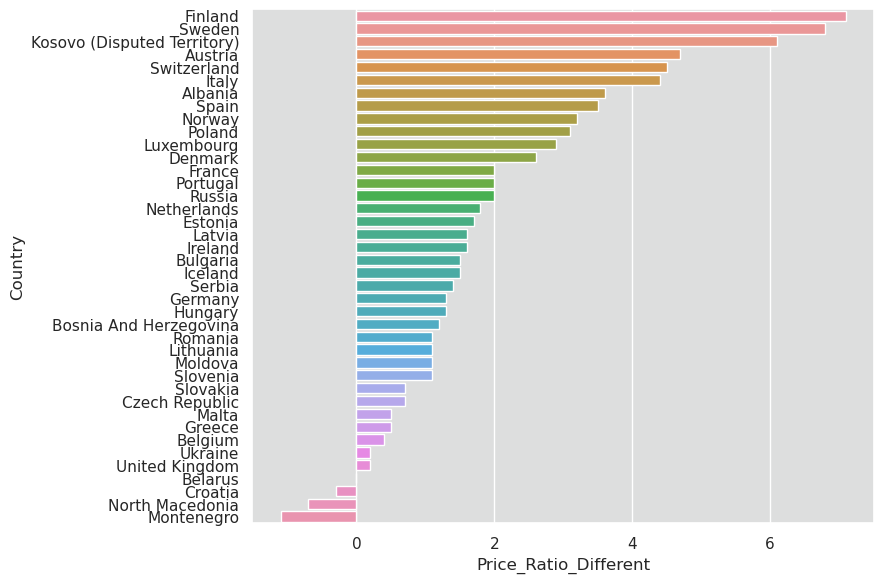

In [69]:
fig, ax = plt.subplots()

sns.barplot(
    data = df_europe,
    y = 'Country',
    x = 'Price_Ratio_Different',
    order = df_europe.sort_values('Price_Ratio_Different', ascending = False).Country,
    ax = ax
)

#ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()

1. 
2. What is the relationship between property size (e.g., square footage, number of rooms) and price?
3. 
4. Are there differences in property prices based on other features like year built, property type, etc.?
5. What factors are most strongly correlated with property price?


/tmp/ipykernel_1706/279779626.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(


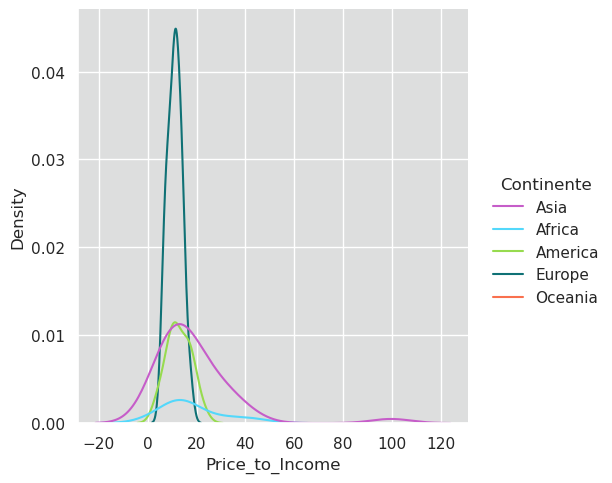

In [70]:
# What is the distribution of property prices? 

sns.displot(
    data = df_prop,
    x = 'Price_to_Income',
    kind = 'kde',
    hue = 'Continente',
    palette= continent_color
)



<Axes: xlabel='Price_to_Income', ylabel='Gross_Rental_Ce'>

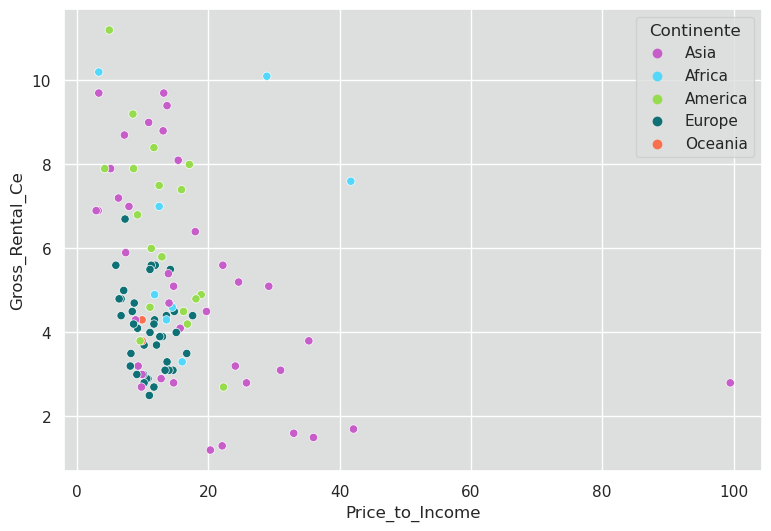

In [71]:
# What is the relationship between property size (e.g., square footage, number of rooms) and price?

sns.scatterplot(
    data = df_prop,
    x = 'Price_to_Income',
    y = 'Gross_Rental_Ce',
    hue = 'Continente',
    palette= continent_color
)

/tmp/ipykernel_1706/2529640589.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<Axes: xlabel='Price_to_Income', ylabel='Gross_Rental_Ce'>

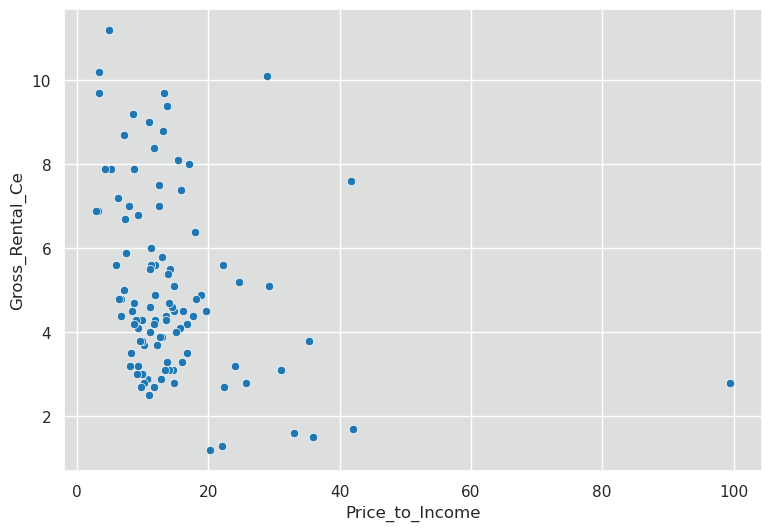

In [72]:
# How do property prices vary by location (e.g., city, neighborhood)?

sns.scatterplot(
    data = df_prop,
    x = 'Price_to_Income',
    y = 'Gross_Rental_Ce',
    palette= 'tab20'
)

---------------------------------

Price to Income Ratio:
- a. How does the Price to Income Ratio vary between the city center and outside of the city center?
- b. Are there any noticeable trends in the Price to Income Ratio over the past few years?
- c. How does the Price to Income Ratio correlate with the percentage of women in the workforce?

Gross Rental Yield:
a. What is the average Gross Rental Yield in the city, and how does it compare to the suburban areas?
b. Are there any seasonal patterns or fluctuations in Gross Rental Yield?
c. How does Gross Rental Yield correlate with changes in the overall housing market?

Price to Rent Ratio:
a. What is the average Price to Rent Ratio for both one-bedroom and three-bedroom apartments?
b. How does the Price to Rent Ratio differ when considering buying to let versus buying to reside?
c. Are there any notable differences in the Price to Rent Ratio between various neighborhoods?

Mortgage as Percentage of Income:
a. How does the Mortgage as Percentage of Income vary across different income brackets?
b. Is there a correlation between Mortgage as Percentage of Income and the average monthly salary?
c. What impact does changes in interest rates have on Mortgage as Percentage of Income?

Loan Affordability Index:
a. How has the Loan Affordability Index changed over the years, and what factors contribute to these changes?
b. Are there specific areas or neighborhoods where the Loan Affordability Index is significantly higher or lower?
c. How does the Loan Affordability Index correlate with broader economic indicators in the region?

/tmp/ipykernel_1706/2656872590.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<Axes: xlabel='Price_Ratio_Ce', ylabel='Price_Ratio_Out'>

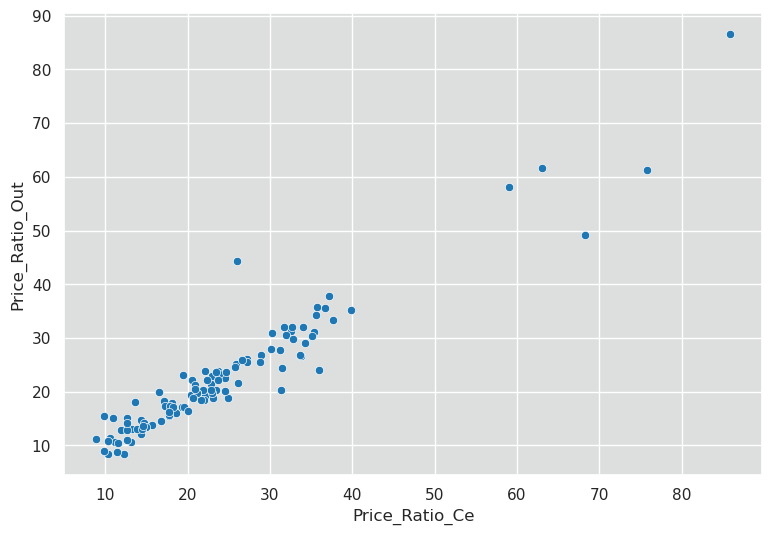

In [73]:
# How does the Price to Income Ratio vary between the city center and outside of the city center?

sns.scatterplot(
    data = df_prop,
    x = 'Price_Ratio_Ce',
    y = 'Price_Ratio_Out',
    palette= 'tab20'
)

/tmp/ipykernel_1706/1930384098.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<Axes: xlabel='Price_Ratio_Ce', ylabel='Price_Ratio_Out'>

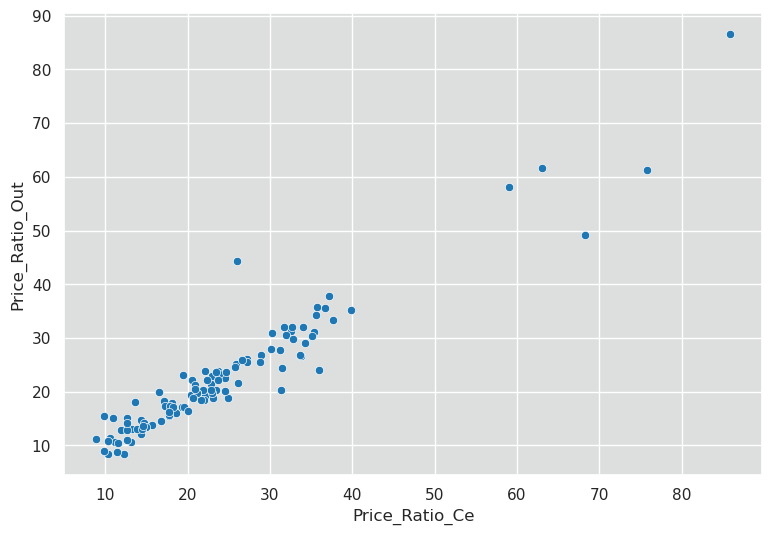

In [74]:
# Are there any noticeable trends in the Price to Income Ratio over the past few years?

sns.scatterplot(
    data = df_prop,
    x = 'Price_Ratio_Ce',
    y = 'Price_Ratio_Out',
    palette= 'tab20'
)

Para obtener insights de calidad durante el análisis exploratorio de estos datos, podrías considerar las siguientes preguntas:

1. **Variación en la Asequibilidad de la Compra de Apartamentos:**
   - ¿Cómo varía el índice de precio a ingreso en diferentes países?
   - ¿Existen patrones geográficos o regionales en la asequibilidad de la vivienda?

2. **Rendimiento de Alquiler:**
   - ¿Cómo se distribuye el rendimiento bruto de alquiler en los diferentes países?
   - ¿Existen países con un rendimiento de alquiler notablemente alto o bajo en comparación con otros?

3. **Relación Precio-Alquiler:**
   - ¿Qué países tienen una relación precio-alquiler más baja, indicando que es más ventajoso comprar que alquilar?
   - ¿Existen países donde la relación precio-alquiler es alta, sugiriendo que alquilar es más atractivo que comprar?

4. **Asequibilidad de la Hipoteca:**
   - ¿Cómo varía el porcentaje de la hipoteca con respecto al ingreso en diferentes países?
   - ¿Hay países donde la asequibilidad de la hipoteca es particularmente baja o alta?

5. **Índice de Asequibilidad del Préstamo:**
   - ¿Cuáles son los países con el índice de asequibilidad de préstamos más alto, indicando una mayor facilidad para obtener préstamos?
   - ¿Hay correlaciones entre el índice de asequibilidad del préstamo y otras métricas como el precio a ingreso o el rendimiento de alquiler?

6. **Comparación entre Centro y Fuera del Centro:**
   - ¿Existe una gran diferencia en el precio por metro cuadrado entre el centro de la ciudad y fuera del centro?
   - ¿Cómo se refleja esta diferencia en el índice de precio a ingreso y en la relación precio-alquiler?

7. **Análisis Comparativo entre Países:**
   - ¿Hay países que se destacan en términos de asequibilidad tanto para la compra como para el alquiler?
   - ¿Existen patrones regionales o continentales en estas métricas?

8. **Identificación de Outliers:**
   - ¿Existen casos atípicos en los datos que podrían ser indicativos de situaciones únicas o problemas en la recopilación de datos?

9. **Correlaciones entre Variables:**
   - ¿Hay correlaciones significativas entre las diferentes métricas, como el rendimiento de alquiler y el índice de precio a ingreso?

Estas preguntas te ayudarán a explorar diferentes aspectos de los datos y a obtener insights valiosos sobre la asequibilidad de la vivienda en diversos países. Recuerda utilizar gráficos y estadísticas descriptivas para respaldar tus observaciones.